# Number of wrong neutrons in log spir polarizer

In [2]:
from new_log_spir.LogSpir import LogSpir, Neutron
import numpy as np
import matplotlib.pyplot as plt
import run_mcstas as rms
import random as rn
import cycler
from scipy.ndimage import gaussian_filter1d
def integrate_between(x_vals: np.array, y_vals: np.array, xmin: float, xmax: float):
    """integrates y_vals corresponding to x_vals from xmin to xmax (best choice)

    Args:
        x_vals (np.array): x_vals to which the xmin and xmax
        y_vals (np.array): y_vals to their x_vals
        xmin (float): lower bound of integration
        xmax (float): upper bound of integration
    """
    min_ind = np.argmin(np.abs(x_vals-xmin))
    max_ind = np.argmin(np.abs(x_vals-xmax))
    try:
        return np.sum(y_vals[min_ind: max_ind+1])
    except IndexError:
        return np.sum(y_vals[min_ind: max_ind])

def adjust_branches(log: LogSpir, angle_neut: float):
    log.branches = 3
    while True:
        angle = (log.branches-1)*log.phi_rot+log.theta_end
        height = np.sin(angle)*log.zend
        if height/log.zend < angle_neut:
            log.branches += 3
        else:
            break


def return_mcstas_simulation(log: LogSpir):
    
    sim = rms.McstasSimulation("/home/cherb/LRZSync/Doktorarbeit/Mieze/Logarithmic_Spiral/mcstas_component/", "reverse_test.instr")
    sim.num_neutrons = log.n_neutrons
    sim.new_compile = False
    #we have to check how many mirror branches we need
    adjust_branches(log, 0.023/(0.675-0.06))
    pd = sim.return_params_dict()
    pd['zmin'] = log.zstart
    pd['zmax'] = log.zend
    pd['mValue'] = log.m
    pd['source_width'] = log.source_width
    pd['L_source'] = log.lambda_source
    pd['dL'] = 0
    pd['phi_rot'] = log.phi_rot
    pd['psi'] = log.psi
    pd['branches'] = log.branches
    print(log.branches)
    data_dict = sim.run_and_return(pd)
    images_dict = sim.return_images_data()
    x = np.linspace(-1.3, 1.3, 1001)
    total = np.sum(images_dict['psdbeforelog.dat'][:1000])
    ints = np.sum(images_dict['psdafterlog.dat'][:1000], axis=0)/total
    
    meta = sim.return_images_metadata()
    met = meta['psdafterlog.dat']
    print(met[' xylimits'])
    #fig, ax = plt.subplots(1)
    #samplemin = -0.25
    #samplemax = 0.25
    #min_ind = np.argmin(np.abs(x-samplemin))
    #max_ind = np.argmin(np.abs(x-samplemax))
    #print(min_ind, max_ind)
    #mcratio = np.sum(ints[min_ind: max_ind])/np.sum(ints)
    #ax.plot(x, ints, marker=' ', linestyle='-')
    #plt.show()
    sim.delete_last_folder()
    return x, ints

def return_phython_sim(log: LogSpir):
    #fig, ax = plt.subplots(1, figsize=(7, 7))
    v0 = 791 #lam = 5
    theta_end = log.theta_end
    theta_range = np.linspace(0, theta_end, 10001)
    z, x = log.return_cart_coords(theta_range)
    hist = []
    ms = 0.0198/(0.675-0.06)
    for slope in np.linspace(-ms, ms, log.n_neutrons//100):
        z0 = 0.675-0.06
        vz = -1
        vx = -slope
        x0 = slope*z0+(rn.uniform(0, 1)-0.5)*log.source_width
        vz, vx = v0*vz/(vx**2+vz**2)**0.5, v0*vx/(vx**2+vz**2)**0.5
        neutron = Neutron(z0, x0, vz, vx)
        path, neutron = log.propagate_neutron(neutron)
        z_path, x_path = zip(*[k[:2] for k in path])
        #ax.set_aspect('equal')

        if neutron.vz > 0:
            z_path=list(z_path)+[2*log.zend]
            x_path=list(x_path)+[neutron.x+neutron.vx/neutron.vz*(2*log.zend-neutron.z)]
            #ax.plot([neutron.z, 2*log.zend], [neutron.x, neutron.x+neutron.vx/neutron.vz*(2*log.zend-neutron.z)])
        else:
            z_path=list(z_path)+[0]
            x_path=list(x_path)+[neutron.x+neutron.vx/neutron.vz*(0-neutron.z)]
            #ax.plot([neutron.z, 0], [neutron.x, neutron.x+neutron.vx/neutron.vz*(0-neutron.z)])
        hist += [x_path[-1]]

    hist = np.histogram(hist, bins = 1001, range=(-0.013, 0.013))
    xhist = 100*(hist[1][:-1]+0.5*(hist[1][1]-hist[1][0]))#all in centimeters
    return xhist, hist[0]

def compare_mcstas_python(logspir: LogSpir, samplemin=-0.3, samplemax=0.3):
    """conducts a mcstas simulation of a spefic logspir object and a acorresponding python simulation and compares the two

    Args:
        logspir (LogSpir): logspir object to simulate
    """
    #first setup the mcstas simulation
    fig, ax = plt.subplots(1)
    log = logspir
    #dealing with the McStas simulation
    x_mac, y_mac = return_mcstas_simulation(log)
    print(x_mac, y_mac)
    y_mac = y_mac/np.sum(y_mac)
    ratio_mac = integrate_between(x_mac, y_mac, samplemin, samplemax)/np.sum(y_mac)
    ax.plot(x_mac, y_mac, marker=' ', label='McStas, wrong portion {:.2}'.format(ratio_mac))

    x_pyth, y_pyth = return_phython_sim(log)
    y_pyth = y_pyth/np.sum(y_pyth)
    ratio_pyth = integrate_between(x_pyth, y_pyth, samplemin, samplemax)/np.sum(y_pyth)
    ax.plot(x_pyth, y_pyth, marker=' ', label='Python, wrong portion {:.2}'.format(ratio_pyth))
    ax.set_xlabel('x (cm)')
    ax.set_ylabel('integrated int (arb. u.)')
    ax.vlines([samplemin, samplemax], 0, 0.007)
    ax.legend()


def investigate_phi_rot(log, source_width: float = 0.002, min_phi=0.2, max_phi=0.8):#this pls
    ratios = []
    th_end = log.theta_end
    print(th_end)
    phi_rots = np.linspace(th_end*min_phi, th_end*max_phi, 11)
    all_y_data = []
    sample_min = -log.source_width/2*100
    sample_max =  log.source_width/2*100
    for ind, phi in enumerate(phi_rots):
        log.phi_rot = phi
        x_mac, y_mac = return_mcstas_simulation(log)
        all_y_data.append(y_mac)
        between = integrate_between(x_mac, y_mac, sample_min, sample_max)
        ratios.append(between)
    all_y_data = np.array(all_y_data)
    color = plt.cm.tab10(np.linspace(0, 1, 11))
    plt.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)
    all_y_data_smoothed = gaussian_filter1d(all_y_data, 2, axis=1)
    ratios_smooth = [integrate_between(x_mac, data, sample_min, sample_max) for ind, data in enumerate(all_y_data_smoothed)]
    totalite= np.max(all_y_data_smoothed)
    print(totalite)
    print(ratios_smooth)
    fig, ax = plt.subplots(1)
    for ind, phi in enumerate(phi_rots): 
        ax.plot(x_mac, all_y_data_smoothed[ind]-totalite*ind, marker=' ', label=r"$\phi_{{rot}}/\theta_{{end}} = {:.2}$".format(phi/log.theta_end), color=color[ind%10])
        ax.hlines(-totalite*ind, -1, 1)
        ax.vlines([sample_min, sample_max], -11*totalite, totalite, linewidth=0.5)
    ax.set_title(r'$\psi = {}°,\ w={}$ mm'.format(log.psi, log.source_width))
    ax.set_xlabel('x (cm)')
    ax.set_ylabel('intensity (arb. u.)')
    ax.legend()
    print(ratios)
    fig, ax = plt.subplots(1)
    for ind, phi in enumerate(phi_rots):
        ax.plot(phi*180/3.1415/(log.theta_end*180/3.1415), ratios_smooth[ind], color=color[ind%10], marker='s')
    ax.set_xlabel(r'$\phi_{rot}/\theta_{end}$')
    ax.set_ylabel('ratio of wrong neutrons')
    ax.set_title(r'$\psi = {}°,\ w={}$ mm'.format(log.psi, log.source_width))
    log.theta_end*180/3.1415
    plt.show()
    return x_mac, all_y_data_smoothed


def plot_polarizations(lam):
    psis = np.array([1.0, 1.15, 1.3, 1.45, 1.6, 1.75, 1.9][::])-0.15/2
    source_widths = np.array([0.5, 2, 4, 6][::1])*0.001
    phi_rots = np.linspace(0.2, 0.855, 12)-0.055/2
    for ind, source_width in enumerate(source_widths):
        all_ratio_reshape=np.genfromtxt('2Dmaps/mapwSMALLER_TIGHTER_{}AA{}.txt'.format(lam, source_width))
        pol = (1-all_ratio_reshape)/(1+all_ratio_reshape)
        fig, ax = plt.subplots(1)
        im = ax.pcolormesh(phi_rots, psis, pol)
        ax.set_yticks(np.array([1.0, 1.15, 1.3, 1.45, 1.6, 1.75][::]))
        fig.colorbar(im)
        ax.set_xlabel(r"$\phi_{rot}/\theta_{end}$")
        ax.set_ylabel("$\psi $ (deg)")
        ax.set_title("Polarization, $w = {}$ mm".format(source_width*1000))

### Test for adjust branches

In [3]:
logspir = LogSpir(0.175, 0.275, 1, 3)
logspir.phi_rot = logspir.theta_end*0.4
adjust_branches(logspir, 0.023/(0.675-0.06))
print(logspir.branches)

12


# Compare all the psi and phi_rot and create a colorplot for a given source width

In [2]:
%matplotlib auto
psis = [1.0, 1.15, 1.3, 1.45, 1.6, 1.75][::]
source_widths = np.array([0.5, 2, 4, 6][::1])*0.001
phi_rots = np.linspace(0.2, 0.8, 11)


#first collect all the data
logspir = LogSpir(0.175, 0.275, 1, 12)
logspir.n_neutrons = 1e5
logspir.m = 5
logspir.lambda_source = 4.5
all_ratios = []
for inds, source_width in enumerate(source_widths):
    logspir.source_width = source_width
    sample_min=-source_width/2*100
    sample_max= source_width/2*100
    for indp, psi in enumerate(psis):
        logspir.psi = psi
        x_mac, y_mac = investigate_phi_rot(logspir)
        for indphi, data in enumerate(y_mac):
            ratio = integrate_between(x_mac, data, sample_min, sample_max)
            all_ratios.append(ratio)
all_ratio_reshape = np.array(all_ratios).reshape((len(source_widths), len(psis), len(phi_rots)))
print(all_ratios)

Using matplotlib backend: <object object at 0x7f19ac6a7750>
0.007889972990664526
21
mcrun /home/cherb/LRZSync/Doktorarbeit/Mieze/Logarithmic_Spiral/mcstas_component/reverse_test.instr source_width=0.0005 source_divergence=3.7116398665896515 L_source=4.5 dL=0 flux=1 zmin=0.175 zmax=0.275 ymin=-1 ymax=1 psi=1.0 phi_rot=0.0015779945981329053 precision=1e-07 max_iterations=10 mValue=5 branches=21 doublesided=1 -n 100000.0
 -1.3 1.3 -1.3 1.3
18
mcrun /home/cherb/LRZSync/Doktorarbeit/Mieze/Logarithmic_Spiral/mcstas_component/reverse_test.instr source_width=0.0005 source_divergence=3.7116398665896515 L_source=4.5 dL=0 flux=1 zmin=0.175 zmax=0.275 ymin=-1 ymax=1 psi=1.0 phi_rot=0.002051392977572777 precision=1e-07 max_iterations=10 mValue=5 branches=18 doublesided=1 -n 100000.0
 -1.3 1.3 -1.3 1.3
15
mcrun /home/cherb/LRZSync/Doktorarbeit/Mieze/Logarithmic_Spiral/mcstas_component/reverse_test.instr source_width=0.0005 source_divergence=3.7116398665896515 L_source=4.5 dL=0 flux=1 zmin=0.175 zmax

/home/cherb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


 -1.3 1.3 -1.3 1.3
18
mcrun /home/cherb/LRZSync/Doktorarbeit/Mieze/Logarithmic_Spiral/mcstas_component/reverse_test.instr source_width=0.002 source_divergence=3.7116398665896515 L_source=4.5 dL=0 flux=1 zmin=0.175 zmax=0.275 ymin=-1 ymax=1 psi=1.75 phi_rot=0.002051392977572777 precision=1e-07 max_iterations=10 mValue=5 branches=18 doublesided=1 -n 100000.0
 -1.3 1.3 -1.3 1.3
15
mcrun /home/cherb/LRZSync/Doktorarbeit/Mieze/Logarithmic_Spiral/mcstas_component/reverse_test.instr source_width=0.002 source_divergence=3.7116398665896515 L_source=4.5 dL=0 flux=1 zmin=0.175 zmax=0.275 ymin=-1 ymax=1 psi=1.75 phi_rot=0.0025247913570126484 precision=1e-07 max_iterations=10 mValue=5 branches=15 doublesided=1 -n 100000.0
 -1.3 1.3 -1.3 1.3
12
mcrun /home/cherb/LRZSync/Doktorarbeit/Mieze/Logarithmic_Spiral/mcstas_component/reverse_test.instr source_width=0.002 source_divergence=3.7116398665896515 L_source=4.5 dL=0 flux=1 zmin=0.175 zmax=0.275 ymin=-1 ymax=1 psi=1.75 phi_rot=0.00299818973645252 prec

### Saving the data after simulations

In [3]:
#Savings
for ind, source_width in enumerate(source_widths):
    np.savetxt('2Dmaps/mapwSMALLER_TIGHTERm5_{}AA{}.txt'.format(logspir.lambda_source, source_width), all_ratio_reshape[ind] ,header="psis = [1.0, 1.15, 1.3, 1.45, 1.6, 1.75] rots = np.linspace(0.4, 1.0, 11)")

# Plot for lambda = 4.5 AA m = 5

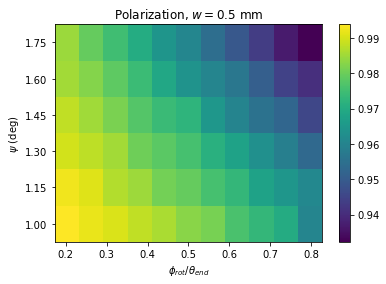

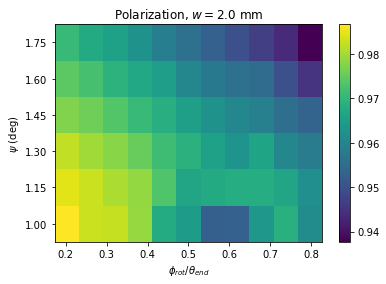

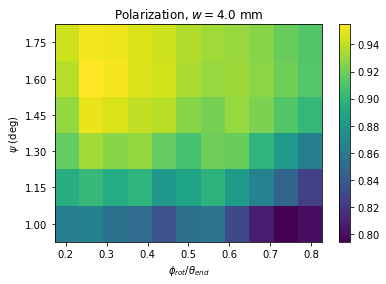

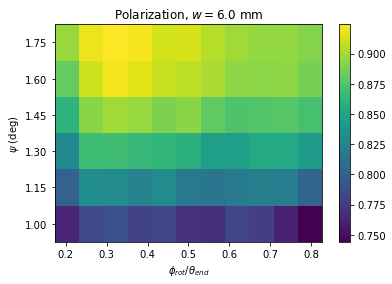

In [3]:
plot_polarizations('m5_4.5')
plt.show()

### Plot for lambda = 3.5 AA

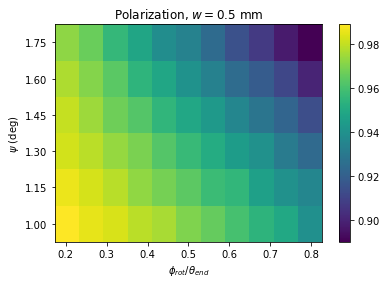

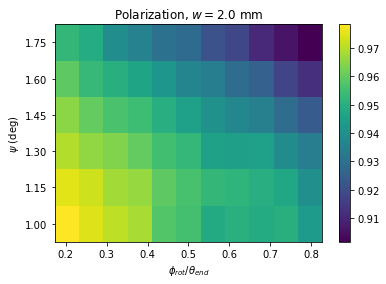

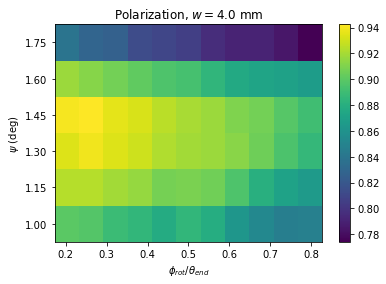

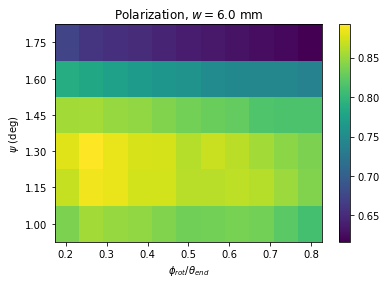

In [5]:
%matplotlib inline
plot_polarizations('3.5')

### Plot for lambad = 4 AA

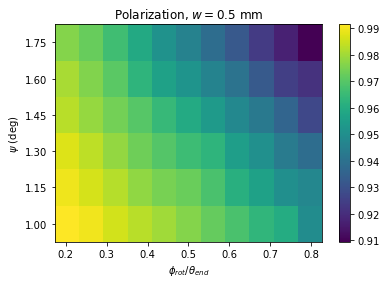

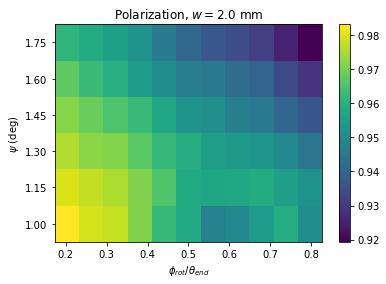

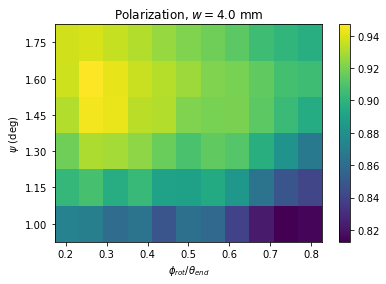

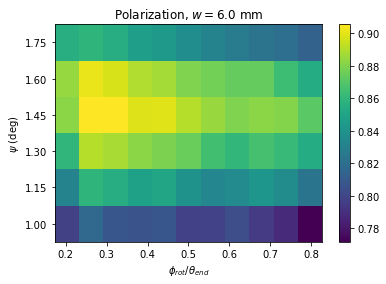

In [8]:
%matplotlib inline
plot_polarizations(4)

### Plot for lambad = 4.5 AA

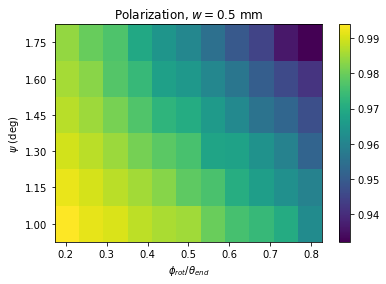

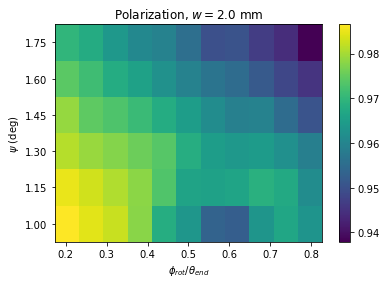

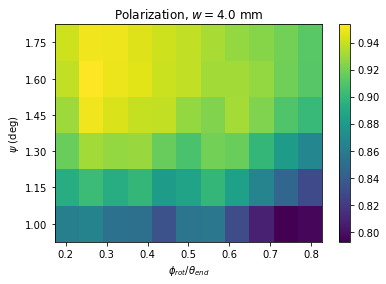

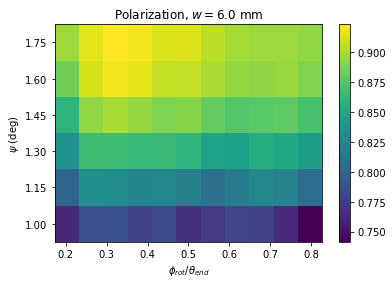

In [5]:
%matplotlib inline
plot_polarizations('4.5')

### Plot for lambad = 5 AA

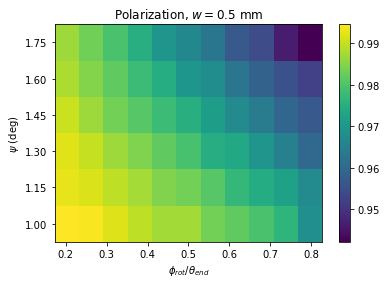

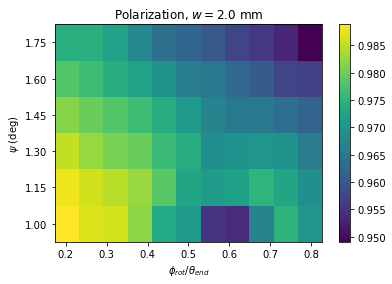

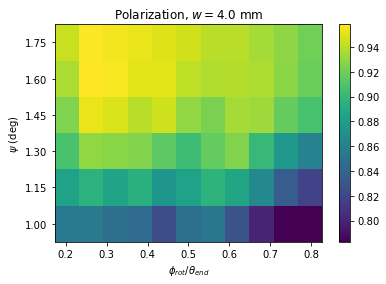

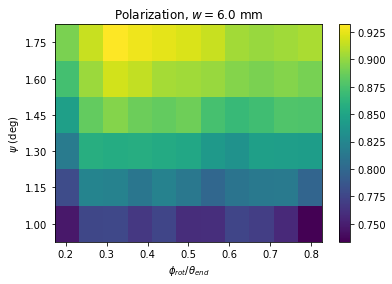

In [7]:
%matplotlib inline
plot_polarizations('5')

### Plot all of them on the same color scale maybe with a fucking slider lul

## constant slitsize w = 0.002 m and psi = 1° with various phi_rot

mcrun /home/cherb/LRZSync/Doktorarbeit/Mieze/Logarithmic_Spiral/mcstas_component/reverse_test.instr source_width=0.002 source_divergence=3.7116398665896515 L_source=5 dL=0 flux=1 zmin=0.15 zmax=0.3 ymin=-1 ymax=1 psi=1 phi_rot=0.004840082765759448 precision=1e-07 max_iterations=10 mValue=6.2 branches=5 doublesided=1 -n 1000000.0
[logspir_test] Initialize
k1 0.000400 k2 -0.000000 k3 -0.000877
k1 0.000280 k2 -0.000000 k3 -0.000614
k1 0.000196 k2 -0.000000 k3 -0.000430
k1 0.000137 k2 -0.000000 k3 -0.000301
k1 0.000096 k2 -0.000000 k3 -0.000211
k1 0.000067 k2 -0.000000 k3 -0.000148
k1 0.000047 k2 -0.000000 k3 -0.000103
k1 0.000033 k2 -0.000000 k3 -0.000072
k1 0.000023 k2 -0.000000 k3 -0.000051
k1 0.000016 k2 -0.000000 k3 -0.000035
k1 0.000011 k2 -0.000000 k3 -0.000025
k1 0.000008 k2 -0.000000 k3 -0.000017
k1 0.000006 k2 -0.000000 k3 -0.000012
k1 0.000004 k2 -0.000000 k3 -0.000009
k1 0.000003 k2 -0.000000 k3 -0.000006
k1 0.000002 k2 -0.000000 k3 -0.000004
k1 0.000001 k2 -0.000000 k3 -0.0000

/usr/share/mcstas/2.6.1/tools/Python/mcrun/mccode.py:200: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if val is not None and val is not '':
INFO: No output directory specified (--dir)
INFO: Using directory: "reverse_test_20220225_163253"
INFO: Using existing c-file: ./reverse_test.c
INFO: Using existing binary: ./reverse_test.out
INFO: ===



Trace ETA 12 [s] % 87 90 
Save [logspir_test]
Detector: psd_before_optic_I=111.27 psd_before_optic_ERR=0.112163 psd_before_optic_N=984142 "beforeoptic.dat"
Detector: psd_monitor_I=51.7891 psd_monitor_ERR=0.0765208 psd_monitor_N=458055 "psdafterlog.dat"

Finally [logspir_test: reverse_test_20220225_163253]. Time: 13 [s] 


INFO: Placing instr file copy /home/cherb/LRZSync/Doktorarbeit/Mieze/Logarithmic_Spiral/mcstas_component/reverse_test.instr in dataset reverse_test_20220225_163253


 -1.3 1.3 -1.3 1.3
mcrun /home/cherb/LRZSync/Doktorarbeit/Mieze/Logarithmic_Spiral/mcstas_component/reverse_test.instr source_width=0.002 source_divergence=3.7116398665896515 L_source=5 dL=0 flux=1 zmin=0.15 zmax=0.3 ymin=-1 ymax=1 psi=1 phi_rot=0.005566095180623365 precision=1e-07 max_iterations=10 mValue=6.2 branches=5 doublesided=1 -n 1000000.0
[logspir_test] Initialize
k1 0.000400 k2 -0.000000 k3 -0.000877
k1 0.000280 k2 -0.000000 k3 -0.000614
k1 0.000196 k2 -0.000000 k3 -0.000430
k1 0.000137 k2 -0.000000 k3 -0.000301
k1 0.000096 k2 -0.000000 k3 -0.000211
k1 0.000067 k2 -0.000000 k3 -0.000148
k1 0.000047 k2 -0.000000 k3 -0.000103
k1 0.000033 k2 -0.000000 k3 -0.000072
k1 0.000023 k2 -0.000000 k3 -0.000051
k1 0.000016 k2 -0.000000 k3 -0.000035
k1 0.000011 k2 -0.000000 k3 -0.000025
k1 0.000008 k2 -0.000000 k3 -0.000017
k1 0.000006 k2 -0.000000 k3 -0.000012
k1 0.000004 k2 -0.000000 k3 -0.000009
k1 0.000003 k2 -0.000000 k3 -0.000006
k1 0.000002 k2 -0.000000 k3 -0.000004
k1 0.000001 k2 -

/usr/share/mcstas/2.6.1/tools/Python/mcrun/mccode.py:200: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if val is not None and val is not '':
INFO: No output directory specified (--dir)
INFO: Using directory: "reverse_test_20220225_163311"
INFO: Using existing c-file: ./reverse_test.c
INFO: Using existing binary: ./reverse_test.out
INFO: ===



Trace ETA 13 [s] % 83 90 
Save [logspir_test]
Detector: psd_before_optic_I=111.264 psd_before_optic_ERR=0.11216 psd_before_optic_N=984086 "beforeoptic.dat"
Detector: psd_monitor_I=51.7339 psd_monitor_ERR=0.07648 psd_monitor_N=457567 "psdafterlog.dat"

Finally [logspir_test: reverse_test_20220225_163311]. Time: 13 [s] 


INFO: Placing instr file copy /home/cherb/LRZSync/Doktorarbeit/Mieze/Logarithmic_Spiral/mcstas_component/reverse_test.instr in dataset reverse_test_20220225_163311


 -1.3 1.3 -1.3 1.3
mcrun /home/cherb/LRZSync/Doktorarbeit/Mieze/Logarithmic_Spiral/mcstas_component/reverse_test.instr source_width=0.002 source_divergence=3.7116398665896515 L_source=5 dL=0 flux=1 zmin=0.15 zmax=0.3 ymin=-1 ymax=1 psi=1 phi_rot=0.006292107595487283 precision=1e-07 max_iterations=10 mValue=6.2 branches=5 doublesided=1 -n 1000000.0
[logspir_test] Initialize
k1 0.000400 k2 -0.000000 k3 -0.000877
k1 0.000280 k2 -0.000000 k3 -0.000614
k1 0.000196 k2 -0.000000 k3 -0.000430
k1 0.000137 k2 -0.000000 k3 -0.000301
k1 0.000096 k2 -0.000000 k3 -0.000211
k1 0.000067 k2 -0.000000 k3 -0.000148
k1 0.000047 k2 -0.000000 k3 -0.000103
k1 0.000033 k2 -0.000000 k3 -0.000072
k1 0.000023 k2 -0.000000 k3 -0.000051
k1 0.000016 k2 -0.000000 k3 -0.000035
k1 0.000011 k2 -0.000000 k3 -0.000025
k1 0.000008 k2 -0.000000 k3 -0.000017
k1 0.000006 k2 -0.000000 k3 -0.000012
k1 0.000004 k2 -0.000000 k3 -0.000009
k1 0.000003 k2 -0.000000 k3 -0.000006
k1 0.000002 k2 -0.000000 k3 -0.000004
k1 0.000001 k2 -

/usr/share/mcstas/2.6.1/tools/Python/mcrun/mccode.py:200: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if val is not None and val is not '':
INFO: No output directory specified (--dir)
INFO: Using directory: "reverse_test_20220225_163329"
INFO: Using existing c-file: ./reverse_test.c
INFO: Using existing binary: ./reverse_test.out
INFO: ===



Trace ETA 13 [s] % 82 90 
Save [logspir_test]
Detector: psd_before_optic_I=111.281 psd_before_optic_ERR=0.112169 psd_before_optic_N=984243 "beforeoptic.dat"
Detector: psd_monitor_I=51.8871 psd_monitor_ERR=0.0765932 psd_monitor_N=458922 "psdafterlog.dat"

Finally [logspir_test: reverse_test_20220225_163329]. Time: 14 [s] 


INFO: Placing instr file copy /home/cherb/LRZSync/Doktorarbeit/Mieze/Logarithmic_Spiral/mcstas_component/reverse_test.instr in dataset reverse_test_20220225_163329


 -1.3 1.3 -1.3 1.3
mcrun /home/cherb/LRZSync/Doktorarbeit/Mieze/Logarithmic_Spiral/mcstas_component/reverse_test.instr source_width=0.002 source_divergence=3.7116398665896515 L_source=5 dL=0 flux=1 zmin=0.15 zmax=0.3 ymin=-1 ymax=1 psi=1 phi_rot=0.007018120010351199 precision=1e-07 max_iterations=10 mValue=6.2 branches=5 doublesided=1 -n 1000000.0
[logspir_test] Initialize
k1 0.000400 k2 -0.000000 k3 -0.000877
k1 0.000280 k2 -0.000000 k3 -0.000614
k1 0.000196 k2 -0.000000 k3 -0.000430
k1 0.000137 k2 -0.000000 k3 -0.000301
k1 0.000096 k2 -0.000000 k3 -0.000211
k1 0.000067 k2 -0.000000 k3 -0.000148
k1 0.000047 k2 -0.000000 k3 -0.000103
k1 0.000033 k2 -0.000000 k3 -0.000072
k1 0.000023 k2 -0.000000 k3 -0.000051
k1 0.000016 k2 -0.000000 k3 -0.000035
k1 0.000011 k2 -0.000000 k3 -0.000025
k1 0.000008 k2 -0.000000 k3 -0.000017
k1 0.000006 k2 -0.000000 k3 -0.000012
k1 0.000004 k2 -0.000000 k3 -0.000009
k1 0.000003 k2 -0.000000 k3 -0.000006
k1 0.000002 k2 -0.000000 k3 -0.000004
k1 0.000001 k2 -

/usr/share/mcstas/2.6.1/tools/Python/mcrun/mccode.py:200: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if val is not None and val is not '':
INFO: No output directory specified (--dir)
INFO: Using directory: "reverse_test_20220225_163348"
INFO: Using existing c-file: ./reverse_test.c
INFO: Using existing binary: ./reverse_test.out
INFO: ===



Trace ETA 12 [s] % 89 90 
Save [logspir_test]
Detector: psd_before_optic_I=111.253 psd_before_optic_ERR=0.112154 psd_before_optic_N=983989 "beforeoptic.dat"
Detector: psd_monitor_I=51.8768 psd_monitor_ERR=0.0765856 psd_monitor_N=458831 "psdafterlog.dat"

Finally [logspir_test: reverse_test_20220225_163348]. Time: 13 [s] 


INFO: Placing instr file copy /home/cherb/LRZSync/Doktorarbeit/Mieze/Logarithmic_Spiral/mcstas_component/reverse_test.instr in dataset reverse_test_20220225_163348


 -1.3 1.3 -1.3 1.3
mcrun /home/cherb/LRZSync/Doktorarbeit/Mieze/Logarithmic_Spiral/mcstas_component/reverse_test.instr source_width=0.002 source_divergence=3.7116398665896515 L_source=5 dL=0 flux=1 zmin=0.15 zmax=0.3 ymin=-1 ymax=1 psi=1 phi_rot=0.0077441324252151165 precision=1e-07 max_iterations=10 mValue=6.2 branches=5 doublesided=1 -n 1000000.0
[logspir_test] Initialize
k1 0.000400 k2 -0.000000 k3 -0.000877
k1 0.000280 k2 -0.000000 k3 -0.000614
k1 0.000196 k2 -0.000000 k3 -0.000430
k1 0.000137 k2 -0.000000 k3 -0.000301
k1 0.000096 k2 -0.000000 k3 -0.000211
k1 0.000067 k2 -0.000000 k3 -0.000148
k1 0.000047 k2 -0.000000 k3 -0.000103
k1 0.000033 k2 -0.000000 k3 -0.000072
k1 0.000023 k2 -0.000000 k3 -0.000051
k1 0.000016 k2 -0.000000 k3 -0.000035
k1 0.000011 k2 -0.000000 k3 -0.000025
k1 0.000008 k2 -0.000000 k3 -0.000017
k1 0.000006 k2 -0.000000 k3 -0.000012
k1 0.000004 k2 -0.000000 k3 -0.000009
k1 0.000003 k2 -0.000000 k3 -0.000006
k1 0.000002 k2 -0.000000 k3 -0.000004
k1 0.000001 k2 

/usr/share/mcstas/2.6.1/tools/Python/mcrun/mccode.py:200: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if val is not None and val is not '':
INFO: No output directory specified (--dir)
INFO: Using directory: "reverse_test_20220225_163405"
INFO: Using existing c-file: ./reverse_test.c
INFO: Using existing binary: ./reverse_test.out
INFO: ===



Trace ETA 11 [s] % 93 
Save [logspir_test]
Detector: psd_before_optic_I=111.261 psd_before_optic_ERR=0.112158 psd_before_optic_N=984059 "beforeoptic.dat"
Detector: psd_monitor_I=51.8607 psd_monitor_ERR=0.0765736 psd_monitor_N=458688 "psdafterlog.dat"

Finally [logspir_test: reverse_test_20220225_163405]. Time: 12 [s] 


INFO: Placing instr file copy /home/cherb/LRZSync/Doktorarbeit/Mieze/Logarithmic_Spiral/mcstas_component/reverse_test.instr in dataset reverse_test_20220225_163405


 -1.3 1.3 -1.3 1.3
mcrun /home/cherb/LRZSync/Doktorarbeit/Mieze/Logarithmic_Spiral/mcstas_component/reverse_test.instr source_width=0.002 source_divergence=3.7116398665896515 L_source=5 dL=0 flux=1 zmin=0.15 zmax=0.3 ymin=-1 ymax=1 psi=1 phi_rot=0.008470144840079033 precision=1e-07 max_iterations=10 mValue=6.2 branches=5 doublesided=1 -n 1000000.0
[logspir_test] Initialize
k1 0.000400 k2 -0.000000 k3 -0.000877
k1 0.000280 k2 -0.000000 k3 -0.000614
k1 0.000196 k2 -0.000000 k3 -0.000430
k1 0.000137 k2 -0.000000 k3 -0.000301
k1 0.000096 k2 -0.000000 k3 -0.000211
k1 0.000067 k2 -0.000000 k3 -0.000148
k1 0.000047 k2 -0.000000 k3 -0.000103
k1 0.000033 k2 -0.000000 k3 -0.000072
k1 0.000023 k2 -0.000000 k3 -0.000051
k1 0.000016 k2 -0.000000 k3 -0.000035
k1 0.000011 k2 -0.000000 k3 -0.000025
k1 0.000008 k2 -0.000000 k3 -0.000017
k1 0.000006 k2 -0.000000 k3 -0.000012
k1 0.000004 k2 -0.000000 k3 -0.000009
k1 0.000003 k2 -0.000000 k3 -0.000006
k1 0.000002 k2 -0.000000 k3 -0.000004
k1 0.000001 k2 -

/usr/share/mcstas/2.6.1/tools/Python/mcrun/mccode.py:200: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if val is not None and val is not '':
INFO: No output directory specified (--dir)
INFO: Using directory: "reverse_test_20220225_163422"
INFO: Using existing c-file: ./reverse_test.c
INFO: Using existing binary: ./reverse_test.out
INFO: ===



Save [logspir_test]
Detector: psd_before_optic_I=111.258 psd_before_optic_ERR=0.112157 psd_before_optic_N=984039 "beforeoptic.dat"
Detector: psd_monitor_I=51.9513 psd_monitor_ERR=0.0766405 psd_monitor_N=459490 "psdafterlog.dat"

Finally [logspir_test: reverse_test_20220225_163422]. Time: 11 [s] 


INFO: Placing instr file copy /home/cherb/LRZSync/Doktorarbeit/Mieze/Logarithmic_Spiral/mcstas_component/reverse_test.instr in dataset reverse_test_20220225_163422


 -1.3 1.3 -1.3 1.3
mcrun /home/cherb/LRZSync/Doktorarbeit/Mieze/Logarithmic_Spiral/mcstas_component/reverse_test.instr source_width=0.002 source_divergence=3.7116398665896515 L_source=5 dL=0 flux=1 zmin=0.15 zmax=0.3 ymin=-1 ymax=1 psi=1 phi_rot=0.00919615725494295 precision=1e-07 max_iterations=10 mValue=6.2 branches=5 doublesided=1 -n 1000000.0
[logspir_test] Initialize
k1 0.000400 k2 -0.000000 k3 -0.000877
k1 0.000280 k2 -0.000000 k3 -0.000614
k1 0.000196 k2 -0.000000 k3 -0.000430
k1 0.000137 k2 -0.000000 k3 -0.000301
k1 0.000096 k2 -0.000000 k3 -0.000211
k1 0.000067 k2 -0.000000 k3 -0.000148
k1 0.000047 k2 -0.000000 k3 -0.000103
k1 0.000033 k2 -0.000000 k3 -0.000072
k1 0.000023 k2 -0.000000 k3 -0.000051
k1 0.000016 k2 -0.000000 k3 -0.000035
k1 0.000011 k2 -0.000000 k3 -0.000025
k1 0.000008 k2 -0.000000 k3 -0.000017
k1 0.000006 k2 -0.000000 k3 -0.000012
k1 0.000004 k2 -0.000000 k3 -0.000009
k1 0.000003 k2 -0.000000 k3 -0.000006
k1 0.000002 k2 -0.000000 k3 -0.000004
k1 0.000001 k2 -0

/usr/share/mcstas/2.6.1/tools/Python/mcrun/mccode.py:200: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if val is not None and val is not '':
INFO: No output directory specified (--dir)
INFO: Using directory: "reverse_test_20220225_163438"
INFO: Using existing c-file: ./reverse_test.c
INFO: Using existing binary: ./reverse_test.out
INFO: ===



Trace ETA 11 [s] % 93 
Save [logspir_test]
Detector: psd_before_optic_I=111.272 psd_before_optic_ERR=0.112164 psd_before_optic_N=984160 "beforeoptic.dat"
Detector: psd_monitor_I=51.8654 psd_monitor_ERR=0.0765771 psd_monitor_N=458730 "psdafterlog.dat"

Finally [logspir_test: reverse_test_20220225_163438]. Time: 12 [s] 


INFO: Placing instr file copy /home/cherb/LRZSync/Doktorarbeit/Mieze/Logarithmic_Spiral/mcstas_component/reverse_test.instr in dataset reverse_test_20220225_163438


 -1.3 1.3 -1.3 1.3
mcrun /home/cherb/LRZSync/Doktorarbeit/Mieze/Logarithmic_Spiral/mcstas_component/reverse_test.instr source_width=0.002 source_divergence=3.7116398665896515 L_source=5 dL=0 flux=1 zmin=0.15 zmax=0.3 ymin=-1 ymax=1 psi=1 phi_rot=0.009922169669806868 precision=1e-07 max_iterations=10 mValue=6.2 branches=5 doublesided=1 -n 1000000.0
[logspir_test] Initialize
k1 0.000400 k2 -0.000000 k3 -0.000877
k1 0.000280 k2 -0.000000 k3 -0.000614
k1 0.000196 k2 -0.000000 k3 -0.000430
k1 0.000137 k2 -0.000000 k3 -0.000301
k1 0.000096 k2 -0.000000 k3 -0.000211
k1 0.000067 k2 -0.000000 k3 -0.000148
k1 0.000047 k2 -0.000000 k3 -0.000103
k1 0.000033 k2 -0.000000 k3 -0.000072
k1 0.000023 k2 -0.000000 k3 -0.000051
k1 0.000016 k2 -0.000000 k3 -0.000035
k1 0.000011 k2 -0.000000 k3 -0.000025
k1 0.000008 k2 -0.000000 k3 -0.000017
k1 0.000006 k2 -0.000000 k3 -0.000012
k1 0.000004 k2 -0.000000 k3 -0.000009
k1 0.000003 k2 -0.000000 k3 -0.000006
k1 0.000002 k2 -0.000000 k3 -0.000004
k1 0.000001 k2 -

/usr/share/mcstas/2.6.1/tools/Python/mcrun/mccode.py:200: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if val is not None and val is not '':
INFO: No output directory specified (--dir)
INFO: Using directory: "reverse_test_20220225_163455"
INFO: Using existing c-file: ./reverse_test.c
INFO: Using existing binary: ./reverse_test.out
INFO: ===



Save [logspir_test]
Detector: psd_before_optic_I=111.246 psd_before_optic_ERR=0.112151 psd_before_optic_N=983932 "beforeoptic.dat"
Detector: psd_monitor_I=51.8319 psd_monitor_ERR=0.0765524 psd_monitor_N=458434 "psdafterlog.dat"

Finally [logspir_test: reverse_test_20220225_163455]. Time: 11 [s] 


INFO: Placing instr file copy /home/cherb/LRZSync/Doktorarbeit/Mieze/Logarithmic_Spiral/mcstas_component/reverse_test.instr in dataset reverse_test_20220225_163455


 -1.3 1.3 -1.3 1.3
mcrun /home/cherb/LRZSync/Doktorarbeit/Mieze/Logarithmic_Spiral/mcstas_component/reverse_test.instr source_width=0.002 source_divergence=3.7116398665896515 L_source=5 dL=0 flux=1 zmin=0.15 zmax=0.3 ymin=-1 ymax=1 psi=1 phi_rot=0.010648182084670785 precision=1e-07 max_iterations=10 mValue=6.2 branches=5 doublesided=1 -n 1000000.0
[logspir_test] Initialize
k1 0.000400 k2 -0.000000 k3 -0.000877
k1 0.000280 k2 -0.000000 k3 -0.000614
k1 0.000196 k2 -0.000000 k3 -0.000430
k1 0.000137 k2 -0.000000 k3 -0.000301
k1 0.000096 k2 -0.000000 k3 -0.000211
k1 0.000067 k2 -0.000000 k3 -0.000148
k1 0.000047 k2 -0.000000 k3 -0.000103
k1 0.000033 k2 -0.000000 k3 -0.000072
k1 0.000023 k2 -0.000000 k3 -0.000051
k1 0.000016 k2 -0.000000 k3 -0.000035
k1 0.000011 k2 -0.000000 k3 -0.000025
k1 0.000008 k2 -0.000000 k3 -0.000017
k1 0.000006 k2 -0.000000 k3 -0.000012
k1 0.000004 k2 -0.000000 k3 -0.000009
k1 0.000003 k2 -0.000000 k3 -0.000006
k1 0.000002 k2 -0.000000 k3 -0.000004
k1 0.000001 k2 -

/usr/share/mcstas/2.6.1/tools/Python/mcrun/mccode.py:200: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if val is not None and val is not '':
INFO: No output directory specified (--dir)
INFO: Using directory: "reverse_test_20220225_163511"
INFO: Using existing c-file: ./reverse_test.c
INFO: Using existing binary: ./reverse_test.out
INFO: ===



Trace ETA 11 [s] % 94 
Save [logspir_test]
Detector: psd_before_optic_I=111.277 psd_before_optic_ERR=0.112166 psd_before_optic_N=984199 "beforeoptic.dat"
Detector: psd_monitor_I=51.8325 psd_monitor_ERR=0.0765528 psd_monitor_N=458439 "psdafterlog.dat"

Finally [logspir_test: reverse_test_20220225_163511]. Time: 12 [s] 


INFO: Placing instr file copy /home/cherb/LRZSync/Doktorarbeit/Mieze/Logarithmic_Spiral/mcstas_component/reverse_test.instr in dataset reverse_test_20220225_163511


 -1.3 1.3 -1.3 1.3
mcrun /home/cherb/LRZSync/Doktorarbeit/Mieze/Logarithmic_Spiral/mcstas_component/reverse_test.instr source_width=0.002 source_divergence=3.7116398665896515 L_source=5 dL=0 flux=1 zmin=0.15 zmax=0.3 ymin=-1 ymax=1 psi=1 phi_rot=0.011374194499534702 precision=1e-07 max_iterations=10 mValue=6.2 branches=5 doublesided=1 -n 1000000.0
[logspir_test] Initialize
k1 0.000400 k2 -0.000000 k3 -0.000877
k1 0.000280 k2 -0.000000 k3 -0.000614
k1 0.000196 k2 -0.000000 k3 -0.000430
k1 0.000137 k2 -0.000000 k3 -0.000301
k1 0.000096 k2 -0.000000 k3 -0.000211
k1 0.000067 k2 -0.000000 k3 -0.000148
k1 0.000047 k2 -0.000000 k3 -0.000103
k1 0.000033 k2 -0.000000 k3 -0.000072
k1 0.000023 k2 -0.000000 k3 -0.000051
k1 0.000016 k2 -0.000000 k3 -0.000035
k1 0.000011 k2 -0.000000 k3 -0.000025
k1 0.000008 k2 -0.000000 k3 -0.000017
k1 0.000006 k2 -0.000000 k3 -0.000012
k1 0.000004 k2 -0.000000 k3 -0.000009
k1 0.000003 k2 -0.000000 k3 -0.000006
k1 0.000002 k2 -0.000000 k3 -0.000004
k1 0.000001 k2 -

/usr/share/mcstas/2.6.1/tools/Python/mcrun/mccode.py:200: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if val is not None and val is not '':
INFO: No output directory specified (--dir)
INFO: Using directory: "reverse_test_20220225_163529"
INFO: Using existing c-file: ./reverse_test.c
INFO: Using existing binary: ./reverse_test.out
INFO: ===



Trace ETA 11 [s] % 97 
Save [logspir_test]
Detector: psd_before_optic_I=111.264 psd_before_optic_ERR=0.11216 psd_before_optic_N=984090 "beforeoptic.dat"
Detector: psd_monitor_I=51.7553 psd_monitor_ERR=0.0764958 psd_monitor_N=457756 "psdafterlog.dat"

Finally [logspir_test: reverse_test_20220225_163529]. Time: 12 [s] 


INFO: Placing instr file copy /home/cherb/LRZSync/Doktorarbeit/Mieze/Logarithmic_Spiral/mcstas_component/reverse_test.instr in dataset reverse_test_20220225_163529


 -1.3 1.3 -1.3 1.3
mcrun /home/cherb/LRZSync/Doktorarbeit/Mieze/Logarithmic_Spiral/mcstas_component/reverse_test.instr source_width=0.002 source_divergence=3.7116398665896515 L_source=5 dL=0 flux=1 zmin=0.15 zmax=0.3 ymin=-1 ymax=1 psi=1 phi_rot=0.01210020691439862 precision=1e-07 max_iterations=10 mValue=6.2 branches=5 doublesided=1 -n 1000000.0
[logspir_test] Initialize
k1 0.000400 k2 -0.000000 k3 -0.000877
k1 0.000280 k2 -0.000000 k3 -0.000614
k1 0.000196 k2 -0.000000 k3 -0.000430
k1 0.000137 k2 -0.000000 k3 -0.000301
k1 0.000096 k2 -0.000000 k3 -0.000211
k1 0.000067 k2 -0.000000 k3 -0.000148
k1 0.000047 k2 -0.000000 k3 -0.000103
k1 0.000033 k2 -0.000000 k3 -0.000072
k1 0.000023 k2 -0.000000 k3 -0.000051
k1 0.000016 k2 -0.000000 k3 -0.000035
k1 0.000011 k2 -0.000000 k3 -0.000025
k1 0.000008 k2 -0.000000 k3 -0.000017
k1 0.000006 k2 -0.000000 k3 -0.000012
k1 0.000004 k2 -0.000000 k3 -0.000009
k1 0.000003 k2 -0.000000 k3 -0.000006
k1 0.000002 k2 -0.000000 k3 -0.000004
k1 0.000001 k2 -0

/usr/share/mcstas/2.6.1/tools/Python/mcrun/mccode.py:200: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if val is not None and val is not '':
INFO: No output directory specified (--dir)
INFO: Using directory: "reverse_test_20220225_163546"
INFO: Using existing c-file: ./reverse_test.c
INFO: Using existing binary: ./reverse_test.out
INFO: ===



Trace ETA 11 [s] % 96 
Save [logspir_test]
Detector: psd_before_optic_I=111.276 psd_before_optic_ERR=0.112166 psd_before_optic_N=984191 "beforeoptic.dat"
Detector: psd_monitor_I=51.8504 psd_monitor_ERR=0.076566 psd_monitor_N=458597 "psdafterlog.dat"

Finally [logspir_test: reverse_test_20220225_163546]. Time: 12 [s] 


INFO: Placing instr file copy /home/cherb/LRZSync/Doktorarbeit/Mieze/Logarithmic_Spiral/mcstas_component/reverse_test.instr in dataset reverse_test_20220225_163546


 -1.3 1.3 -1.3 1.3
[0.22638899512142685, 0.21183483730127978, 0.2643521962047216, 0.2908733924461262, 0.29201064054146547, 0.25950197162797245, 0.21048772663857088, 0.16811508127284971, 0.13140600164624033, 0.11181493184020927, 0.11103956906361073]


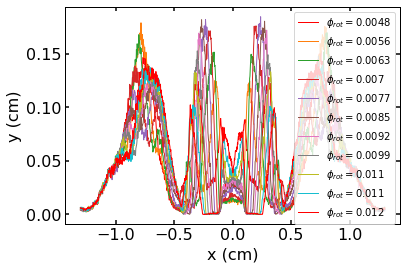

In [3]:

ratios = []
log = LogSpir(0.15, 0.3, 1, 5)
log.source_width = 0.002
log.n_neutrons = 1e6
th_end = log.theta_end
phi_rots = np.linspace(th_end*0.4, th_end, 11)
all_y_data = []
sample_min = -0.3
sample_max =  0.3
fig, ax = plt.subplots(1)
for ind, phi in enumerate(phi_rots):
    log.phi_rot = phi
    x_mac, y_mac = return_mcstas_simulation(log)
    all_y_data.append(y_mac)
    between = integrate_between(x_mac, y_mac, sample_min, sample_max)
    ax.plot(x_mac, y_mac, marker=' ', label=r"$\phi_{{rot}} = {:.2}$".format(phi))
    ratios.append(between/np.sum(y_mac))
ax.set_xlabel('x (cm)')
ax.set_ylabel('y (cm)')
ax.legend()
print(ratios)
all_y_data = np.array(all_y_data)


In [35]:
%matplotlib auto
from scipy.ndimage import gaussian_filter1d
import cycler
sample_min = -0.1
sample_max = 0.1
color = plt.cm.tab10(np.linspace(0, 1, 11))
plt.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)
all_y_data_smoothed = gaussian_filter1d(all_y_data, 2, axis=1)
ratios_smooth = [integrate_between(x_mac, data, sample_min, sample_max)/np.sum(data) for ind, data in enumerate(all_y_data_smoothed)]
print(ratios_smooth)
fig, ax = plt.subplots(1)
for ind, phi in enumerate(phi_rots): 
    ax.plot(x_mac, all_y_data_smoothed[ind]-0.1*ind, marker=' ', label=r"$\phi_{{rot}}/\theta_{{end}} = {:.2}$".format(phi/log.theta_end), color=color[ind%10])
    ax.hlines(-0.1*ind, -1, 1)
    ax.vlines([sample_min, sample_max], -1, 0.2, linewidth=0.5)
ax.set_xlabel('x (cm)')
ax.set_ylabel('intensity (arb. u.)')
ax.legend()
print(ratios)
all_y_data = np.array(all_y_data)



Using matplotlib backend: Qt5Agg
[0.05688262459339926, 0.021019029631730118, 0.018443413469669764, 0.02195929700389718, 0.028541925542856776, 0.03496485223462276, 0.04003712330691448, 0.04878440378073018, 0.05988758587783292, 0.075075870641624, 0.09235522098757502]
[0.22638899512142685, 0.21183483730127978, 0.2643521962047216, 0.2908733924461262, 0.29201064054146547, 0.25950197162797245, 0.21048772663857088, 0.16811508127284971, 0.13140600164624033, 0.11181493184020927, 0.11103956906361073]


In [36]:
fig, ax = plt.subplots(1)
for ind, phi in enumerate(phi_rots):
    ax.plot(phi*180/3.1415/(log.theta_end*180/3.1415), ratios_smooth[ind], color=color[ind%10])
ax.set_xlabel(r'$\phi_{rot}/\theta_{end}$')
ax.set_ylabel('ratio of wrong neutrons')
log.theta_end*180/3.1415

0.6933112349488306

## constant slitsize w = 0.004 m with various phi_rot

In [38]:

ratios = []
log = LogSpir(0.15, 0.3, 1, 5)
log.source_width = 0.004
log.n_neutrons = 1e6
th_end = log.theta_end
phi_rots = np.linspace(th_end*0.4, th_end, 11)
all_y_data = []
sample_min = -0.2
sample_max =  0.2
fig, ax = plt.subplots(1)
for ind, phi in enumerate(phi_rots):
    log.phi_rot = phi
    x_mac, y_mac = return_mcstas_simulation(log)
    all_y_data.append(y_mac)
    between = integrate_between(x_mac, y_mac, sample_min, sample_max)
    ax.plot(x_mac, y_mac, marker=' ', label=r"$\phi_{{rot}} = {:.2}$".format(phi))
    ratios.append(between/np.sum(y_mac))
ax.set_xlabel('x (cm)')
ax.set_ylabel('y (cm)')
ax.legend()
print(ratios)
all_y_data = np.array(all_y_data)


mcrun /home/cherb/LRZSync/Doktorarbeit/Mieze/Logarithmic_Spiral/mcstas_component/reverse_test.instr source_width=0.004 source_divergence=3.7116398665896515 L_source=5 dL=0 flux=1 zmin=0.15 zmax=0.3 ymin=-1 ymax=1 psi=1 phi_rot=0.004840082765759448 precision=1e-07 max_iterations=10 mValue=6.2 branches=5 doublesided=1 -n 1000000.0
[logspir_test] Initialize
k1 0.000400 k2 -0.000000 k3 -0.000877
k1 0.000280 k2 -0.000000 k3 -0.000614
k1 0.000196 k2 -0.000000 k3 -0.000430
k1 0.000137 k2 -0.000000 k3 -0.000301
k1 0.000096 k2 -0.000000 k3 -0.000211
k1 0.000067 k2 -0.000000 k3 -0.000148
k1 0.000047 k2 -0.000000 k3 -0.000103
k1 0.000033 k2 -0.000000 k3 -0.000072
k1 0.000023 k2 -0.000000 k3 -0.000051
k1 0.000016 k2 -0.000000 k3 -0.000035
k1 0.000011 k2 -0.000000 k3 -0.000025
k1 0.000008 k2 -0.000000 k3 -0.000017
k1 0.000006 k2 -0.000000 k3 -0.000012
k1 0.000004 k2 -0.000000 k3 -0.000009
k1 0.000003 k2 -0.000000 k3 -0.000006
k1 0.000002 k2 -0.000000 k3 -0.000004
k1 0.000001 k2 -0.000000 k3 -0.0000

/usr/share/mcstas/2.6.1/tools/Python/mcrun/mccode.py:200: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if val is not None and val is not '':
INFO: No output directory specified (--dir)
INFO: Using directory: "reverse_test_20220225_173241"
INFO: Using existing c-file: ./reverse_test.c
INFO: Using existing binary: ./reverse_test.out
INFO: ===



Trace ETA 12 [s] % 85 90 
Save [logspir_test]
Detector: psd_before_optic_I=219.759 psd_before_optic_ERR=0.22292 psd_before_optic_N=971842 "beforeoptic.dat"
Detector: psd_monitor_I=97.5368 psd_monitor_ERR=0.148511 psd_monitor_N=431338 "psdafterlog.dat"

Finally [logspir_test: reverse_test_20220225_173241]. Time: 13 [s] 


INFO: Placing instr file copy /home/cherb/LRZSync/Doktorarbeit/Mieze/Logarithmic_Spiral/mcstas_component/reverse_test.instr in dataset reverse_test_20220225_173241


 -1.3 1.3 -1.3 1.3
mcrun /home/cherb/LRZSync/Doktorarbeit/Mieze/Logarithmic_Spiral/mcstas_component/reverse_test.instr source_width=0.004 source_divergence=3.7116398665896515 L_source=5 dL=0 flux=1 zmin=0.15 zmax=0.3 ymin=-1 ymax=1 psi=1 phi_rot=0.005566095180623365 precision=1e-07 max_iterations=10 mValue=6.2 branches=5 doublesided=1 -n 1000000.0
[logspir_test] Initialize
k1 0.000400 k2 -0.000000 k3 -0.000877
k1 0.000280 k2 -0.000000 k3 -0.000614
k1 0.000196 k2 -0.000000 k3 -0.000430
k1 0.000137 k2 -0.000000 k3 -0.000301
k1 0.000096 k2 -0.000000 k3 -0.000211
k1 0.000067 k2 -0.000000 k3 -0.000148
k1 0.000047 k2 -0.000000 k3 -0.000103
k1 0.000033 k2 -0.000000 k3 -0.000072
k1 0.000023 k2 -0.000000 k3 -0.000051
k1 0.000016 k2 -0.000000 k3 -0.000035
k1 0.000011 k2 -0.000000 k3 -0.000025
k1 0.000008 k2 -0.000000 k3 -0.000017
k1 0.000006 k2 -0.000000 k3 -0.000012
k1 0.000004 k2 -0.000000 k3 -0.000009
k1 0.000003 k2 -0.000000 k3 -0.000006
k1 0.000002 k2 -0.000000 k3 -0.000004
k1 0.000001 k2 -

/usr/share/mcstas/2.6.1/tools/Python/mcrun/mccode.py:200: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if val is not None and val is not '':
INFO: No output directory specified (--dir)
INFO: Using directory: "reverse_test_20220225_173259"
INFO: Using existing c-file: ./reverse_test.c
INFO: Using existing binary: ./reverse_test.out
INFO: ===



Trace ETA 12 [s] % 87 90 
Save [logspir_test]
Detector: psd_before_optic_I=219.703 psd_before_optic_ERR=0.222891 psd_before_optic_N=971595 "beforeoptic.dat"
Detector: psd_monitor_I=97.324 psd_monitor_ERR=0.148349 psd_monitor_N=430397 "psdafterlog.dat"

Finally [logspir_test: reverse_test_20220225_173259]. Time: 13 [s] 


INFO: Placing instr file copy /home/cherb/LRZSync/Doktorarbeit/Mieze/Logarithmic_Spiral/mcstas_component/reverse_test.instr in dataset reverse_test_20220225_173259


 -1.3 1.3 -1.3 1.3
mcrun /home/cherb/LRZSync/Doktorarbeit/Mieze/Logarithmic_Spiral/mcstas_component/reverse_test.instr source_width=0.004 source_divergence=3.7116398665896515 L_source=5 dL=0 flux=1 zmin=0.15 zmax=0.3 ymin=-1 ymax=1 psi=1 phi_rot=0.006292107595487283 precision=1e-07 max_iterations=10 mValue=6.2 branches=5 doublesided=1 -n 1000000.0
[logspir_test] Initialize
k1 0.000400 k2 -0.000000 k3 -0.000877
k1 0.000280 k2 -0.000000 k3 -0.000614
k1 0.000196 k2 -0.000000 k3 -0.000430
k1 0.000137 k2 -0.000000 k3 -0.000301
k1 0.000096 k2 -0.000000 k3 -0.000211
k1 0.000067 k2 -0.000000 k3 -0.000148
k1 0.000047 k2 -0.000000 k3 -0.000103
k1 0.000033 k2 -0.000000 k3 -0.000072
k1 0.000023 k2 -0.000000 k3 -0.000051
k1 0.000016 k2 -0.000000 k3 -0.000035
k1 0.000011 k2 -0.000000 k3 -0.000025
k1 0.000008 k2 -0.000000 k3 -0.000017
k1 0.000006 k2 -0.000000 k3 -0.000012
k1 0.000004 k2 -0.000000 k3 -0.000009
k1 0.000003 k2 -0.000000 k3 -0.000006
k1 0.000002 k2 -0.000000 k3 -0.000004
k1 0.000001 k2 -

/usr/share/mcstas/2.6.1/tools/Python/mcrun/mccode.py:200: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if val is not None and val is not '':
INFO: No output directory specified (--dir)
INFO: Using directory: "reverse_test_20220225_173317"
INFO: Using existing c-file: ./reverse_test.c
INFO: Using existing binary: ./reverse_test.out
INFO: ===



Trace ETA 12 [s] % 88 90 
Save [logspir_test]
Detector: psd_before_optic_I=219.716 psd_before_optic_ERR=0.222898 psd_before_optic_N=971653 "beforeoptic.dat"
Detector: psd_monitor_I=97.8006 psd_monitor_ERR=0.148712 psd_monitor_N=432505 "psdafterlog.dat"

Finally [logspir_test: reverse_test_20220225_173317]. Time: 13 [s] 


INFO: Placing instr file copy /home/cherb/LRZSync/Doktorarbeit/Mieze/Logarithmic_Spiral/mcstas_component/reverse_test.instr in dataset reverse_test_20220225_173317


 -1.3 1.3 -1.3 1.3
mcrun /home/cherb/LRZSync/Doktorarbeit/Mieze/Logarithmic_Spiral/mcstas_component/reverse_test.instr source_width=0.004 source_divergence=3.7116398665896515 L_source=5 dL=0 flux=1 zmin=0.15 zmax=0.3 ymin=-1 ymax=1 psi=1 phi_rot=0.007018120010351199 precision=1e-07 max_iterations=10 mValue=6.2 branches=5 doublesided=1 -n 1000000.0
[logspir_test] Initialize
k1 0.000400 k2 -0.000000 k3 -0.000877
k1 0.000280 k2 -0.000000 k3 -0.000614
k1 0.000196 k2 -0.000000 k3 -0.000430
k1 0.000137 k2 -0.000000 k3 -0.000301
k1 0.000096 k2 -0.000000 k3 -0.000211
k1 0.000067 k2 -0.000000 k3 -0.000148
k1 0.000047 k2 -0.000000 k3 -0.000103
k1 0.000033 k2 -0.000000 k3 -0.000072
k1 0.000023 k2 -0.000000 k3 -0.000051
k1 0.000016 k2 -0.000000 k3 -0.000035
k1 0.000011 k2 -0.000000 k3 -0.000025
k1 0.000008 k2 -0.000000 k3 -0.000017
k1 0.000006 k2 -0.000000 k3 -0.000012
k1 0.000004 k2 -0.000000 k3 -0.000009
k1 0.000003 k2 -0.000000 k3 -0.000006
k1 0.000002 k2 -0.000000 k3 -0.000004
k1 0.000001 k2 -

/usr/share/mcstas/2.6.1/tools/Python/mcrun/mccode.py:200: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if val is not None and val is not '':
INFO: No output directory specified (--dir)
INFO: Using directory: "reverse_test_20220225_173335"
INFO: Using existing c-file: ./reverse_test.c
INFO: Using existing binary: ./reverse_test.out
INFO: ===



Trace ETA 13 [s] % 83 90 
Save [logspir_test]
Detector: psd_before_optic_I=219.711 psd_before_optic_ERR=0.222895 psd_before_optic_N=971631 "beforeoptic.dat"
Detector: psd_monitor_I=97.828 psd_monitor_ERR=0.148733 psd_monitor_N=432626 "psdafterlog.dat"

Finally [logspir_test: reverse_test_20220225_173335]. Time: 14 [s] 


INFO: Placing instr file copy /home/cherb/LRZSync/Doktorarbeit/Mieze/Logarithmic_Spiral/mcstas_component/reverse_test.instr in dataset reverse_test_20220225_173335


 -1.3 1.3 -1.3 1.3
mcrun /home/cherb/LRZSync/Doktorarbeit/Mieze/Logarithmic_Spiral/mcstas_component/reverse_test.instr source_width=0.004 source_divergence=3.7116398665896515 L_source=5 dL=0 flux=1 zmin=0.15 zmax=0.3 ymin=-1 ymax=1 psi=1 phi_rot=0.0077441324252151165 precision=1e-07 max_iterations=10 mValue=6.2 branches=5 doublesided=1 -n 1000000.0
[logspir_test] Initialize
k1 0.000400 k2 -0.000000 k3 -0.000877
k1 0.000280 k2 -0.000000 k3 -0.000614
k1 0.000196 k2 -0.000000 k3 -0.000430
k1 0.000137 k2 -0.000000 k3 -0.000301
k1 0.000096 k2 -0.000000 k3 -0.000211
k1 0.000067 k2 -0.000000 k3 -0.000148
k1 0.000047 k2 -0.000000 k3 -0.000103
k1 0.000033 k2 -0.000000 k3 -0.000072
k1 0.000023 k2 -0.000000 k3 -0.000051
k1 0.000016 k2 -0.000000 k3 -0.000035
k1 0.000011 k2 -0.000000 k3 -0.000025
k1 0.000008 k2 -0.000000 k3 -0.000017
k1 0.000006 k2 -0.000000 k3 -0.000012
k1 0.000004 k2 -0.000000 k3 -0.000009
k1 0.000003 k2 -0.000000 k3 -0.000006
k1 0.000002 k2 -0.000000 k3 -0.000004
k1 0.000001 k2 

/usr/share/mcstas/2.6.1/tools/Python/mcrun/mccode.py:200: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if val is not None and val is not '':
INFO: No output directory specified (--dir)
INFO: Using directory: "reverse_test_20220225_173354"
INFO: Using existing c-file: ./reverse_test.c
INFO: Using existing binary: ./reverse_test.out
INFO: ===



Trace ETA 11 [s] % 96 
Save [logspir_test]
Detector: psd_before_optic_I=219.743 psd_before_optic_ERR=0.222912 psd_before_optic_N=971771 "beforeoptic.dat"
Detector: psd_monitor_I=98.1434 psd_monitor_ERR=0.148972 psd_monitor_N=434021 "psdafterlog.dat"

Finally [logspir_test: reverse_test_20220225_173354]. Time: 12 [s] 


INFO: Placing instr file copy /home/cherb/LRZSync/Doktorarbeit/Mieze/Logarithmic_Spiral/mcstas_component/reverse_test.instr in dataset reverse_test_20220225_173354


 -1.3 1.3 -1.3 1.3
mcrun /home/cherb/LRZSync/Doktorarbeit/Mieze/Logarithmic_Spiral/mcstas_component/reverse_test.instr source_width=0.004 source_divergence=3.7116398665896515 L_source=5 dL=0 flux=1 zmin=0.15 zmax=0.3 ymin=-1 ymax=1 psi=1 phi_rot=0.008470144840079033 precision=1e-07 max_iterations=10 mValue=6.2 branches=5 doublesided=1 -n 1000000.0
[logspir_test] Initialize
k1 0.000400 k2 -0.000000 k3 -0.000877
k1 0.000280 k2 -0.000000 k3 -0.000614
k1 0.000196 k2 -0.000000 k3 -0.000430
k1 0.000137 k2 -0.000000 k3 -0.000301
k1 0.000096 k2 -0.000000 k3 -0.000211
k1 0.000067 k2 -0.000000 k3 -0.000148
k1 0.000047 k2 -0.000000 k3 -0.000103
k1 0.000033 k2 -0.000000 k3 -0.000072
k1 0.000023 k2 -0.000000 k3 -0.000051
k1 0.000016 k2 -0.000000 k3 -0.000035
k1 0.000011 k2 -0.000000 k3 -0.000025
k1 0.000008 k2 -0.000000 k3 -0.000017
k1 0.000006 k2 -0.000000 k3 -0.000012
k1 0.000004 k2 -0.000000 k3 -0.000009
k1 0.000003 k2 -0.000000 k3 -0.000006
k1 0.000002 k2 -0.000000 k3 -0.000004
k1 0.000001 k2 -

/usr/share/mcstas/2.6.1/tools/Python/mcrun/mccode.py:200: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if val is not None and val is not '':
INFO: No output directory specified (--dir)
INFO: Using directory: "reverse_test_20220225_173412"
INFO: Using existing c-file: ./reverse_test.c
INFO: Using existing binary: ./reverse_test.out
INFO: ===



Trace ETA 12 [s] % 85 90 
Save [logspir_test]
Detector: psd_before_optic_I=219.67 psd_before_optic_ERR=0.222875 psd_before_optic_N=971451 "beforeoptic.dat"
Detector: psd_monitor_I=97.8278 psd_monitor_ERR=0.148733 psd_monitor_N=432625 "psdafterlog.dat"

Finally [logspir_test: reverse_test_20220225_173412]. Time: 14 [s] 


INFO: Placing instr file copy /home/cherb/LRZSync/Doktorarbeit/Mieze/Logarithmic_Spiral/mcstas_component/reverse_test.instr in dataset reverse_test_20220225_173412


 -1.3 1.3 -1.3 1.3
mcrun /home/cherb/LRZSync/Doktorarbeit/Mieze/Logarithmic_Spiral/mcstas_component/reverse_test.instr source_width=0.004 source_divergence=3.7116398665896515 L_source=5 dL=0 flux=1 zmin=0.15 zmax=0.3 ymin=-1 ymax=1 psi=1 phi_rot=0.00919615725494295 precision=1e-07 max_iterations=10 mValue=6.2 branches=5 doublesided=1 -n 1000000.0
[logspir_test] Initialize
k1 0.000400 k2 -0.000000 k3 -0.000877
k1 0.000280 k2 -0.000000 k3 -0.000614
k1 0.000196 k2 -0.000000 k3 -0.000430
k1 0.000137 k2 -0.000000 k3 -0.000301
k1 0.000096 k2 -0.000000 k3 -0.000211
k1 0.000067 k2 -0.000000 k3 -0.000148
k1 0.000047 k2 -0.000000 k3 -0.000103
k1 0.000033 k2 -0.000000 k3 -0.000072
k1 0.000023 k2 -0.000000 k3 -0.000051
k1 0.000016 k2 -0.000000 k3 -0.000035
k1 0.000011 k2 -0.000000 k3 -0.000025
k1 0.000008 k2 -0.000000 k3 -0.000017
k1 0.000006 k2 -0.000000 k3 -0.000012
k1 0.000004 k2 -0.000000 k3 -0.000009
k1 0.000003 k2 -0.000000 k3 -0.000006
k1 0.000002 k2 -0.000000 k3 -0.000004
k1 0.000001 k2 -0

/usr/share/mcstas/2.6.1/tools/Python/mcrun/mccode.py:200: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if val is not None and val is not '':
INFO: No output directory specified (--dir)
INFO: Using directory: "reverse_test_20220225_173431"
INFO: Using existing c-file: ./reverse_test.c
INFO: Using existing binary: ./reverse_test.out
INFO: ===



Trace ETA 13 [s] % 79 80 90 
Save [logspir_test]
Detector: psd_before_optic_I=219.728 psd_before_optic_ERR=0.222904 psd_before_optic_N=971707 "beforeoptic.dat"
Detector: psd_monitor_I=97.8192 psd_monitor_ERR=0.148726 psd_monitor_N=432587 "psdafterlog.dat"

Finally [logspir_test: reverse_test_20220225_173431]. Time: 15 [s] 


INFO: Placing instr file copy /home/cherb/LRZSync/Doktorarbeit/Mieze/Logarithmic_Spiral/mcstas_component/reverse_test.instr in dataset reverse_test_20220225_173431


 -1.3 1.3 -1.3 1.3
mcrun /home/cherb/LRZSync/Doktorarbeit/Mieze/Logarithmic_Spiral/mcstas_component/reverse_test.instr source_width=0.004 source_divergence=3.7116398665896515 L_source=5 dL=0 flux=1 zmin=0.15 zmax=0.3 ymin=-1 ymax=1 psi=1 phi_rot=0.009922169669806868 precision=1e-07 max_iterations=10 mValue=6.2 branches=5 doublesided=1 -n 1000000.0
[logspir_test] Initialize
k1 0.000400 k2 -0.000000 k3 -0.000877
k1 0.000280 k2 -0.000000 k3 -0.000614
k1 0.000196 k2 -0.000000 k3 -0.000430
k1 0.000137 k2 -0.000000 k3 -0.000301
k1 0.000096 k2 -0.000000 k3 -0.000211
k1 0.000067 k2 -0.000000 k3 -0.000148
k1 0.000047 k2 -0.000000 k3 -0.000103
k1 0.000033 k2 -0.000000 k3 -0.000072
k1 0.000023 k2 -0.000000 k3 -0.000051
k1 0.000016 k2 -0.000000 k3 -0.000035
k1 0.000011 k2 -0.000000 k3 -0.000025
k1 0.000008 k2 -0.000000 k3 -0.000017
k1 0.000006 k2 -0.000000 k3 -0.000012
k1 0.000004 k2 -0.000000 k3 -0.000009
k1 0.000003 k2 -0.000000 k3 -0.000006
k1 0.000002 k2 -0.000000 k3 -0.000004
k1 0.000001 k2 -

/usr/share/mcstas/2.6.1/tools/Python/mcrun/mccode.py:200: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if val is not None and val is not '':
INFO: No output directory specified (--dir)
INFO: Using directory: "reverse_test_20220225_173452"
INFO: Using existing c-file: ./reverse_test.c
INFO: Using existing binary: ./reverse_test.out
INFO: ===



Save [logspir_test]
Detector: psd_before_optic_I=219.731 psd_before_optic_ERR=0.222905 psd_before_optic_N=971718 "beforeoptic.dat"
Detector: psd_monitor_I=97.7285 psd_monitor_ERR=0.148657 psd_monitor_N=432186 "psdafterlog.dat"

Finally [logspir_test: reverse_test_20220225_173452]. Time: 11 [s] 


INFO: Placing instr file copy /home/cherb/LRZSync/Doktorarbeit/Mieze/Logarithmic_Spiral/mcstas_component/reverse_test.instr in dataset reverse_test_20220225_173452


 -1.3 1.3 -1.3 1.3
mcrun /home/cherb/LRZSync/Doktorarbeit/Mieze/Logarithmic_Spiral/mcstas_component/reverse_test.instr source_width=0.004 source_divergence=3.7116398665896515 L_source=5 dL=0 flux=1 zmin=0.15 zmax=0.3 ymin=-1 ymax=1 psi=1 phi_rot=0.010648182084670785 precision=1e-07 max_iterations=10 mValue=6.2 branches=5 doublesided=1 -n 1000000.0
[logspir_test] Initialize
k1 0.000400 k2 -0.000000 k3 -0.000877
k1 0.000280 k2 -0.000000 k3 -0.000614
k1 0.000196 k2 -0.000000 k3 -0.000430
k1 0.000137 k2 -0.000000 k3 -0.000301
k1 0.000096 k2 -0.000000 k3 -0.000211
k1 0.000067 k2 -0.000000 k3 -0.000148
k1 0.000047 k2 -0.000000 k3 -0.000103
k1 0.000033 k2 -0.000000 k3 -0.000072
k1 0.000023 k2 -0.000000 k3 -0.000051
k1 0.000016 k2 -0.000000 k3 -0.000035
k1 0.000011 k2 -0.000000 k3 -0.000025
k1 0.000008 k2 -0.000000 k3 -0.000017
k1 0.000006 k2 -0.000000 k3 -0.000012
k1 0.000004 k2 -0.000000 k3 -0.000009
k1 0.000003 k2 -0.000000 k3 -0.000006
k1 0.000002 k2 -0.000000 k3 -0.000004
k1 0.000001 k2 -

/usr/share/mcstas/2.6.1/tools/Python/mcrun/mccode.py:200: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if val is not None and val is not '':
INFO: No output directory specified (--dir)
INFO: Using directory: "reverse_test_20220225_173508"
INFO: Using existing c-file: ./reverse_test.c
INFO: Using existing binary: ./reverse_test.out
INFO: ===



Trace ETA 12 [s] % 90 
Save [logspir_test]
Detector: psd_before_optic_I=219.733 psd_before_optic_ERR=0.222907 psd_before_optic_N=971730 "beforeoptic.dat"
Detector: psd_monitor_I=97.5926 psd_monitor_ERR=0.148554 psd_monitor_N=431585 "psdafterlog.dat"

Finally [logspir_test: reverse_test_20220225_173508]. Time: 13 [s] 


INFO: Placing instr file copy /home/cherb/LRZSync/Doktorarbeit/Mieze/Logarithmic_Spiral/mcstas_component/reverse_test.instr in dataset reverse_test_20220225_173508


 -1.3 1.3 -1.3 1.3
mcrun /home/cherb/LRZSync/Doktorarbeit/Mieze/Logarithmic_Spiral/mcstas_component/reverse_test.instr source_width=0.004 source_divergence=3.7116398665896515 L_source=5 dL=0 flux=1 zmin=0.15 zmax=0.3 ymin=-1 ymax=1 psi=1 phi_rot=0.011374194499534702 precision=1e-07 max_iterations=10 mValue=6.2 branches=5 doublesided=1 -n 1000000.0
[logspir_test] Initialize
k1 0.000400 k2 -0.000000 k3 -0.000877
k1 0.000280 k2 -0.000000 k3 -0.000614
k1 0.000196 k2 -0.000000 k3 -0.000430
k1 0.000137 k2 -0.000000 k3 -0.000301
k1 0.000096 k2 -0.000000 k3 -0.000211
k1 0.000067 k2 -0.000000 k3 -0.000148
k1 0.000047 k2 -0.000000 k3 -0.000103
k1 0.000033 k2 -0.000000 k3 -0.000072
k1 0.000023 k2 -0.000000 k3 -0.000051
k1 0.000016 k2 -0.000000 k3 -0.000035
k1 0.000011 k2 -0.000000 k3 -0.000025
k1 0.000008 k2 -0.000000 k3 -0.000017
k1 0.000006 k2 -0.000000 k3 -0.000012
k1 0.000004 k2 -0.000000 k3 -0.000009
k1 0.000003 k2 -0.000000 k3 -0.000006
k1 0.000002 k2 -0.000000 k3 -0.000004
k1 0.000001 k2 -

/usr/share/mcstas/2.6.1/tools/Python/mcrun/mccode.py:200: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if val is not None and val is not '':
INFO: No output directory specified (--dir)
INFO: Using directory: "reverse_test_20220225_173526"
INFO: Using existing c-file: ./reverse_test.c
INFO: Using existing binary: ./reverse_test.out
INFO: ===



Trace ETA 12 [s] % 89 90 
Save [logspir_test]
Detector: psd_before_optic_I=219.678 psd_before_optic_ERR=0.222879 psd_before_optic_N=971483 "beforeoptic.dat"
Detector: psd_monitor_I=97.4771 psd_monitor_ERR=0.148466 psd_monitor_N=431074 "psdafterlog.dat"

Finally [logspir_test: reverse_test_20220225_173526]. Time: 13 [s] 


INFO: Placing instr file copy /home/cherb/LRZSync/Doktorarbeit/Mieze/Logarithmic_Spiral/mcstas_component/reverse_test.instr in dataset reverse_test_20220225_173526


 -1.3 1.3 -1.3 1.3
mcrun /home/cherb/LRZSync/Doktorarbeit/Mieze/Logarithmic_Spiral/mcstas_component/reverse_test.instr source_width=0.004 source_divergence=3.7116398665896515 L_source=5 dL=0 flux=1 zmin=0.15 zmax=0.3 ymin=-1 ymax=1 psi=1 phi_rot=0.01210020691439862 precision=1e-07 max_iterations=10 mValue=6.2 branches=5 doublesided=1 -n 1000000.0


/usr/share/mcstas/2.6.1/tools/Python/mcrun/mccode.py:200: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if val is not None and val is not '':
INFO: No output directory specified (--dir)
INFO: Using directory: "reverse_test_20220225_173544"
INFO: Using existing c-file: ./reverse_test.c
INFO: Using existing binary: ./reverse_test.out
INFO: ===


[logspir_test] Initialize
k1 0.000400 k2 -0.000000 k3 -0.000877
k1 0.000280 k2 -0.000000 k3 -0.000614
k1 0.000196 k2 -0.000000 k3 -0.000430
k1 0.000137 k2 -0.000000 k3 -0.000301
k1 0.000096 k2 -0.000000 k3 -0.000211
k1 0.000067 k2 -0.000000 k3 -0.000148
k1 0.000047 k2 -0.000000 k3 -0.000103
k1 0.000033 k2 -0.000000 k3 -0.000072
k1 0.000023 k2 -0.000000 k3 -0.000051
k1 0.000016 k2 -0.000000 k3 -0.000035
k1 0.000011 k2 -0.000000 k3 -0.000025
k1 0.000008 k2 -0.000000 k3 -0.000017
k1 0.000006 k2 -0.000000 k3 -0.000012
k1 0.000004 k2 -0.000000 k3 -0.000009
k1 0.000003 k2 -0.000000 k3 -0.000006
k1 0.000002 k2 -0.000000 k3 -0.000004
k1 0.000001 k2 -0.000000 k3 -0.000003
k1 0.000001 k2 -0.000000 k3 -0.000002
k1 0.000001 k2 -0.000000 k3 -0.000001
k1 0.000000 k2 -0.000000 k3 -0.000001
k1 0.000000 k2 -0.000000 k3 -0.000001
k1 0.000000 k2 -0.000000 k3 -0.000000
k1 0.000000 k2 -0.000000 k3 -0.000000
k1 0.000000 k2 -0.000000 k3 -0.000000
k1 0.000000 k2 -0.000000 k3 -0.000000
k1 0.000000 k2 -0.000000

INFO: Placing instr file copy /home/cherb/LRZSync/Doktorarbeit/Mieze/Logarithmic_Spiral/mcstas_component/reverse_test.instr in dataset reverse_test_20220225_173544


 -1.3 1.3 -1.3 1.3
[0.15303422730870975, 0.1415387263254841, 0.1421955069605771, 0.11620566530716557, 0.08994571108251899, 0.07993669113821346, 0.07600088854471355, 0.07703371223389782, 0.0876729486775784, 0.10399271855638254, 0.12313903257227286]


In [39]:
%matplotlib auto
from scipy.ndimage import gaussian_filter1d
import cycler
sample_min = -0.2
sample_max = 0.2
color = plt.cm.tab10(np.linspace(0, 1, 11))
plt.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)
all_y_data_smoothed = gaussian_filter1d(all_y_data, 2, axis=1)
ratios_smooth = [integrate_between(x_mac, data, sample_min, sample_max)/np.sum(data) for ind, data in enumerate(all_y_data_smoothed)]
print(ratios_smooth)
fig, ax = plt.subplots(1)
for ind, phi in enumerate(phi_rots): 
    ax.plot(x_mac, all_y_data_smoothed[ind]-0.1*ind, marker=' ', label=r"$\phi_{{rot}}/\theta_{{end}} = {:.2}$".format(phi/log.theta_end), color=color[ind%10])
    ax.hlines(-0.1*ind, -1, 1)
    ax.vlines([sample_min, sample_max], -1, 0.2, linewidth=0.5)
ax.set_xlabel('x (cm)')
ax.set_ylabel('intensity (arb. u.)')
ax.legend()
print(ratios)
all_y_data = np.array(all_y_data)



Using matplotlib backend: Qt5Agg
[0.15299187027698366, 0.1413638947104562, 0.14221359648637577, 0.11599632167973502, 0.08985954514894846, 0.07993906461503825, 0.07603962423788943, 0.0771284553498463, 0.08761382470070858, 0.10383153710906029, 0.12292861397434683]
[0.15303422730870975, 0.1415387263254841, 0.1421955069605771, 0.11620566530716557, 0.08994571108251899, 0.07993669113821346, 0.07600088854471355, 0.07703371223389782, 0.0876729486775784, 0.10399271855638254, 0.12313903257227286]


## constant slitsize w = 0.001 m with various phi_rot

In [41]:

ratios = []
log = LogSpir(0.15, 0.3, 1, 5)
log.source_width = 0.001
log.n_neutrons = 1e6
th_end = log.theta_end
phi_rots = np.linspace(th_end*0.4, th_end, 11)
all_y_data = []
sample_min = -0.3
sample_max =  0.3
fig, ax = plt.subplots(1)
for ind, phi in enumerate(phi_rots):
    log.phi_rot = phi
    x_mac, y_mac = return_mcstas_simulation(log)
    all_y_data.append(y_mac)
    between = integrate_between(x_mac, y_mac, sample_min, sample_max)
    ax.plot(x_mac, y_mac, marker=' ', label=r"$\phi_{{rot}} = {:.2}$".format(phi))
    ratios.append(between/np.sum(y_mac))
ax.set_xlabel('x (cm)')
ax.set_ylabel('y (cm)')
ax.legend()
print(ratios)
all_y_data = np.array(all_y_data)


mcrun /home/cherb/LRZSync/Doktorarbeit/Mieze/Logarithmic_Spiral/mcstas_component/reverse_test.instr source_width=0.001 source_divergence=3.7116398665896515 L_source=5 dL=0 flux=1 zmin=0.15 zmax=0.3 ymin=-1 ymax=1 psi=1 phi_rot=0.004840082765759448 precision=1e-07 max_iterations=10 mValue=6.2 branches=5 doublesided=1 -n 1000000.0
[logspir_test] Initialize
k1 0.000400 k2 -0.000000 k3 -0.000877
k1 0.000280 k2 -0.000000 k3 -0.000614
k1 0.000196 k2 -0.000000 k3 -0.000430
k1 0.000137 k2 -0.000000 k3 -0.000301
k1 0.000096 k2 -0.000000 k3 -0.000211
k1 0.000067 k2 -0.000000 k3 -0.000148
k1 0.000047 k2 -0.000000 k3 -0.000103
k1 0.000033 k2 -0.000000 k3 -0.000072
k1 0.000023 k2 -0.000000 k3 -0.000051
k1 0.000016 k2 -0.000000 k3 -0.000035
k1 0.000011 k2 -0.000000 k3 -0.000025
k1 0.000008 k2 -0.000000 k3 -0.000017
k1 0.000006 k2 -0.000000 k3 -0.000012
k1 0.000004 k2 -0.000000 k3 -0.000009
k1 0.000003 k2 -0.000000 k3 -0.000006
k1 0.000002 k2 -0.000000 k3 -0.000004
k1 0.000001 k2 -0.000000 k3 -0.0000

/usr/share/mcstas/2.6.1/tools/Python/mcrun/mccode.py:200: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if val is not None and val is not '':
INFO: No output directory specified (--dir)
INFO: Using directory: "reverse_test_20220225_174935"
INFO: Using existing c-file: ./reverse_test.c
INFO: Using existing binary: ./reverse_test.out
INFO: ===



Trace ETA 12 [s] % 86 90 
Save [logspir_test]
Detector: psd_before_optic_I=55.9678 psd_before_optic_ERR=0.0562489 psd_before_optic_N=990028 "beforeoptic.dat"
Detector: psd_monitor_I=26.6797 psd_monitor_ERR=0.0388361 psd_monitor_N=471943 "psdafterlog.dat"

Finally [logspir_test: reverse_test_20220225_174935]. Time: 14 [s] 


INFO: Placing instr file copy /home/cherb/LRZSync/Doktorarbeit/Mieze/Logarithmic_Spiral/mcstas_component/reverse_test.instr in dataset reverse_test_20220225_174935


 -1.3 1.3 -1.3 1.3
mcrun /home/cherb/LRZSync/Doktorarbeit/Mieze/Logarithmic_Spiral/mcstas_component/reverse_test.instr source_width=0.001 source_divergence=3.7116398665896515 L_source=5 dL=0 flux=1 zmin=0.15 zmax=0.3 ymin=-1 ymax=1 psi=1 phi_rot=0.005566095180623365 precision=1e-07 max_iterations=10 mValue=6.2 branches=5 doublesided=1 -n 1000000.0
[logspir_test] Initialize
k1 0.000400 k2 -0.000000 k3 -0.000877
k1 0.000280 k2 -0.000000 k3 -0.000614
k1 0.000196 k2 -0.000000 k3 -0.000430
k1 0.000137 k2 -0.000000 k3 -0.000301
k1 0.000096 k2 -0.000000 k3 -0.000211
k1 0.000067 k2 -0.000000 k3 -0.000148
k1 0.000047 k2 -0.000000 k3 -0.000103
k1 0.000033 k2 -0.000000 k3 -0.000072
k1 0.000023 k2 -0.000000 k3 -0.000051
k1 0.000016 k2 -0.000000 k3 -0.000035
k1 0.000011 k2 -0.000000 k3 -0.000025
k1 0.000008 k2 -0.000000 k3 -0.000017
k1 0.000006 k2 -0.000000 k3 -0.000012
k1 0.000004 k2 -0.000000 k3 -0.000009
k1 0.000003 k2 -0.000000 k3 -0.000006
k1 0.000002 k2 -0.000000 k3 -0.000004
k1 0.000001 k2 -

/usr/share/mcstas/2.6.1/tools/Python/mcrun/mccode.py:200: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if val is not None and val is not '':
INFO: No output directory specified (--dir)
INFO: Using directory: "reverse_test_20220225_174954"
INFO: Using existing c-file: ./reverse_test.c
INFO: Using existing binary: ./reverse_test.out
INFO: ===



Trace ETA 12 [s] % 87 90 
Save [logspir_test]
Detector: psd_before_optic_I=55.9637 psd_before_optic_ERR=0.0562469 psd_before_optic_N=989955 "beforeoptic.dat"
Detector: psd_monitor_I=26.7101 psd_monitor_ERR=0.0388582 psd_monitor_N=472482 "psdafterlog.dat"

Finally [logspir_test: reverse_test_20220225_174954]. Time: 13 [s] 


INFO: Placing instr file copy /home/cherb/LRZSync/Doktorarbeit/Mieze/Logarithmic_Spiral/mcstas_component/reverse_test.instr in dataset reverse_test_20220225_174954


 -1.3 1.3 -1.3 1.3
mcrun /home/cherb/LRZSync/Doktorarbeit/Mieze/Logarithmic_Spiral/mcstas_component/reverse_test.instr source_width=0.001 source_divergence=3.7116398665896515 L_source=5 dL=0 flux=1 zmin=0.15 zmax=0.3 ymin=-1 ymax=1 psi=1 phi_rot=0.006292107595487283 precision=1e-07 max_iterations=10 mValue=6.2 branches=5 doublesided=1 -n 1000000.0
[logspir_test] Initialize
k1 0.000400 k2 -0.000000 k3 -0.000877
k1 0.000280 k2 -0.000000 k3 -0.000614
k1 0.000196 k2 -0.000000 k3 -0.000430
k1 0.000137 k2 -0.000000 k3 -0.000301
k1 0.000096 k2 -0.000000 k3 -0.000211
k1 0.000067 k2 -0.000000 k3 -0.000148
k1 0.000047 k2 -0.000000 k3 -0.000103
k1 0.000033 k2 -0.000000 k3 -0.000072
k1 0.000023 k2 -0.000000 k3 -0.000051
k1 0.000016 k2 -0.000000 k3 -0.000035
k1 0.000011 k2 -0.000000 k3 -0.000025
k1 0.000008 k2 -0.000000 k3 -0.000017
k1 0.000006 k2 -0.000000 k3 -0.000012
k1 0.000004 k2 -0.000000 k3 -0.000009
k1 0.000003 k2 -0.000000 k3 -0.000006
k1 0.000002 k2 -0.000000 k3 -0.000004
k1 0.000001 k2 -

/usr/share/mcstas/2.6.1/tools/Python/mcrun/mccode.py:200: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if val is not None and val is not '':
INFO: No output directory specified (--dir)
INFO: Using directory: "reverse_test_20220225_175012"
INFO: Using existing c-file: ./reverse_test.c
INFO: Using existing binary: ./reverse_test.out
INFO: ===



Trace ETA 11 [s] % 95 
Save [logspir_test]
Detector: psd_before_optic_I=55.9724 psd_before_optic_ERR=0.0562513 psd_before_optic_N=990110 "beforeoptic.dat"
Detector: psd_monitor_I=26.6911 psd_monitor_ERR=0.0388444 psd_monitor_N=472146 "psdafterlog.dat"

Finally [logspir_test: reverse_test_20220225_175012]. Time: 12 [s] 


INFO: Placing instr file copy /home/cherb/LRZSync/Doktorarbeit/Mieze/Logarithmic_Spiral/mcstas_component/reverse_test.instr in dataset reverse_test_20220225_175012


 -1.3 1.3 -1.3 1.3
mcrun /home/cherb/LRZSync/Doktorarbeit/Mieze/Logarithmic_Spiral/mcstas_component/reverse_test.instr source_width=0.001 source_divergence=3.7116398665896515 L_source=5 dL=0 flux=1 zmin=0.15 zmax=0.3 ymin=-1 ymax=1 psi=1 phi_rot=0.007018120010351199 precision=1e-07 max_iterations=10 mValue=6.2 branches=5 doublesided=1 -n 1000000.0
[logspir_test] Initialize
k1 0.000400 k2 -0.000000 k3 -0.000877
k1 0.000280 k2 -0.000000 k3 -0.000614
k1 0.000196 k2 -0.000000 k3 -0.000430
k1 0.000137 k2 -0.000000 k3 -0.000301
k1 0.000096 k2 -0.000000 k3 -0.000211
k1 0.000067 k2 -0.000000 k3 -0.000148
k1 0.000047 k2 -0.000000 k3 -0.000103
k1 0.000033 k2 -0.000000 k3 -0.000072
k1 0.000023 k2 -0.000000 k3 -0.000051
k1 0.000016 k2 -0.000000 k3 -0.000035
k1 0.000011 k2 -0.000000 k3 -0.000025
k1 0.000008 k2 -0.000000 k3 -0.000017
k1 0.000006 k2 -0.000000 k3 -0.000012
k1 0.000004 k2 -0.000000 k3 -0.000009
k1 0.000003 k2 -0.000000 k3 -0.000006
k1 0.000002 k2 -0.000000 k3 -0.000004
k1 0.000001 k2 -

/usr/share/mcstas/2.6.1/tools/Python/mcrun/mccode.py:200: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if val is not None and val is not '':
INFO: No output directory specified (--dir)
INFO: Using directory: "reverse_test_20220225_175029"
INFO: Using existing c-file: ./reverse_test.c
INFO: Using existing binary: ./reverse_test.out
INFO: ===



Trace ETA 11 [s] % 92 
Save [logspir_test]
Detector: psd_before_optic_I=55.9832 psd_before_optic_ERR=0.0562567 psd_before_optic_N=990301 "beforeoptic.dat"
Detector: psd_monitor_I=26.7636 psd_monitor_ERR=0.0388971 psd_monitor_N=473428 "psdafterlog.dat"

Finally [logspir_test: reverse_test_20220225_175029]. Time: 12 [s] 


INFO: Placing instr file copy /home/cherb/LRZSync/Doktorarbeit/Mieze/Logarithmic_Spiral/mcstas_component/reverse_test.instr in dataset reverse_test_20220225_175029


 -1.3 1.3 -1.3 1.3
mcrun /home/cherb/LRZSync/Doktorarbeit/Mieze/Logarithmic_Spiral/mcstas_component/reverse_test.instr source_width=0.001 source_divergence=3.7116398665896515 L_source=5 dL=0 flux=1 zmin=0.15 zmax=0.3 ymin=-1 ymax=1 psi=1 phi_rot=0.0077441324252151165 precision=1e-07 max_iterations=10 mValue=6.2 branches=5 doublesided=1 -n 1000000.0
[logspir_test] Initialize
k1 0.000400 k2 -0.000000 k3 -0.000877
k1 0.000280 k2 -0.000000 k3 -0.000614
k1 0.000196 k2 -0.000000 k3 -0.000430
k1 0.000137 k2 -0.000000 k3 -0.000301
k1 0.000096 k2 -0.000000 k3 -0.000211
k1 0.000067 k2 -0.000000 k3 -0.000148
k1 0.000047 k2 -0.000000 k3 -0.000103
k1 0.000033 k2 -0.000000 k3 -0.000072
k1 0.000023 k2 -0.000000 k3 -0.000051
k1 0.000016 k2 -0.000000 k3 -0.000035
k1 0.000011 k2 -0.000000 k3 -0.000025
k1 0.000008 k2 -0.000000 k3 -0.000017
k1 0.000006 k2 -0.000000 k3 -0.000012
k1 0.000004 k2 -0.000000 k3 -0.000009
k1 0.000003 k2 -0.000000 k3 -0.000006
k1 0.000002 k2 -0.000000 k3 -0.000004
k1 0.000001 k2 

/usr/share/mcstas/2.6.1/tools/Python/mcrun/mccode.py:200: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if val is not None and val is not '':
INFO: No output directory specified (--dir)
INFO: Using directory: "reverse_test_20220225_175046"
INFO: Using existing c-file: ./reverse_test.c
INFO: Using existing binary: ./reverse_test.out
INFO: ===



Save [logspir_test]
Detector: psd_before_optic_I=55.9763 psd_before_optic_ERR=0.0562532 psd_before_optic_N=990179 "beforeoptic.dat"
Detector: psd_monitor_I=26.749 psd_monitor_ERR=0.0388865 psd_monitor_N=473169 "psdafterlog.dat"

Finally [logspir_test: reverse_test_20220225_175046]. Time: 11 [s] 


INFO: Placing instr file copy /home/cherb/LRZSync/Doktorarbeit/Mieze/Logarithmic_Spiral/mcstas_component/reverse_test.instr in dataset reverse_test_20220225_175046


 -1.3 1.3 -1.3 1.3
mcrun /home/cherb/LRZSync/Doktorarbeit/Mieze/Logarithmic_Spiral/mcstas_component/reverse_test.instr source_width=0.001 source_divergence=3.7116398665896515 L_source=5 dL=0 flux=1 zmin=0.15 zmax=0.3 ymin=-1 ymax=1 psi=1 phi_rot=0.008470144840079033 precision=1e-07 max_iterations=10 mValue=6.2 branches=5 doublesided=1 -n 1000000.0
[logspir_test] Initialize
k1 0.000400 k2 -0.000000 k3 -0.000877
k1 0.000280 k2 -0.000000 k3 -0.000614
k1 0.000196 k2 -0.000000 k3 -0.000430
k1 0.000137 k2 -0.000000 k3 -0.000301
k1 0.000096 k2 -0.000000 k3 -0.000211
k1 0.000067 k2 -0.000000 k3 -0.000148
k1 0.000047 k2 -0.000000 k3 -0.000103
k1 0.000033 k2 -0.000000 k3 -0.000072
k1 0.000023 k2 -0.000000 k3 -0.000051
k1 0.000016 k2 -0.000000 k3 -0.000035
k1 0.000011 k2 -0.000000 k3 -0.000025
k1 0.000008 k2 -0.000000 k3 -0.000017
k1 0.000006 k2 -0.000000 k3 -0.000012
k1 0.000004 k2 -0.000000 k3 -0.000009
k1 0.000003 k2 -0.000000 k3 -0.000006
k1 0.000002 k2 -0.000000 k3 -0.000004
k1 0.000001 k2 -

/usr/share/mcstas/2.6.1/tools/Python/mcrun/mccode.py:200: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if val is not None and val is not '':
INFO: No output directory specified (--dir)
INFO: Using directory: "reverse_test_20220225_175102"
INFO: Using existing c-file: ./reverse_test.c
INFO: Using existing binary: ./reverse_test.out
INFO: ===



Trace ETA 11 [s] % 98 
Save [logspir_test]
Detector: psd_before_optic_I=55.9615 psd_before_optic_ERR=0.0562458 psd_before_optic_N=989917 "beforeoptic.dat"
Detector: psd_monitor_I=26.6742 psd_monitor_ERR=0.0388321 psd_monitor_N=471846 "psdafterlog.dat"

Finally [logspir_test: reverse_test_20220225_175102]. Time: 12 [s] 


INFO: Placing instr file copy /home/cherb/LRZSync/Doktorarbeit/Mieze/Logarithmic_Spiral/mcstas_component/reverse_test.instr in dataset reverse_test_20220225_175102


 -1.3 1.3 -1.3 1.3
mcrun /home/cherb/LRZSync/Doktorarbeit/Mieze/Logarithmic_Spiral/mcstas_component/reverse_test.instr source_width=0.001 source_divergence=3.7116398665896515 L_source=5 dL=0 flux=1 zmin=0.15 zmax=0.3 ymin=-1 ymax=1 psi=1 phi_rot=0.00919615725494295 precision=1e-07 max_iterations=10 mValue=6.2 branches=5 doublesided=1 -n 1000000.0
[logspir_test] Initialize
k1 0.000400 k2 -0.000000 k3 -0.000877
k1 0.000280 k2 -0.000000 k3 -0.000614
k1 0.000196 k2 -0.000000 k3 -0.000430
k1 0.000137 k2 -0.000000 k3 -0.000301
k1 0.000096 k2 -0.000000 k3 -0.000211
k1 0.000067 k2 -0.000000 k3 -0.000148
k1 0.000047 k2 -0.000000 k3 -0.000103
k1 0.000033 k2 -0.000000 k3 -0.000072
k1 0.000023 k2 -0.000000 k3 -0.000051
k1 0.000016 k2 -0.000000 k3 -0.000035
k1 0.000011 k2 -0.000000 k3 -0.000025
k1 0.000008 k2 -0.000000 k3 -0.000017
k1 0.000006 k2 -0.000000 k3 -0.000012
k1 0.000004 k2 -0.000000 k3 -0.000009
k1 0.000003 k2 -0.000000 k3 -0.000006
k1 0.000002 k2 -0.000000 k3 -0.000004
k1 0.000001 k2 -0

/usr/share/mcstas/2.6.1/tools/Python/mcrun/mccode.py:200: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if val is not None and val is not '':
INFO: No output directory specified (--dir)
INFO: Using directory: "reverse_test_20220225_175118"
INFO: Using existing c-file: ./reverse_test.c
INFO: Using existing binary: ./reverse_test.out
INFO: ===



Save [logspir_test]
Detector: psd_before_optic_I=55.973 psd_before_optic_ERR=0.0562516 psd_before_optic_N=990121 "beforeoptic.dat"
Detector: psd_monitor_I=26.6842 psd_monitor_ERR=0.0388394 psd_monitor_N=472024 "psdafterlog.dat"

Finally [logspir_test: reverse_test_20220225_175118]. Time: 11 [s] 


INFO: Placing instr file copy /home/cherb/LRZSync/Doktorarbeit/Mieze/Logarithmic_Spiral/mcstas_component/reverse_test.instr in dataset reverse_test_20220225_175118


 -1.3 1.3 -1.3 1.3
mcrun /home/cherb/LRZSync/Doktorarbeit/Mieze/Logarithmic_Spiral/mcstas_component/reverse_test.instr source_width=0.001 source_divergence=3.7116398665896515 L_source=5 dL=0 flux=1 zmin=0.15 zmax=0.3 ymin=-1 ymax=1 psi=1 phi_rot=0.009922169669806868 precision=1e-07 max_iterations=10 mValue=6.2 branches=5 doublesided=1 -n 1000000.0
[logspir_test] Initialize
k1 0.000400 k2 -0.000000 k3 -0.000877
k1 0.000280 k2 -0.000000 k3 -0.000614
k1 0.000196 k2 -0.000000 k3 -0.000430
k1 0.000137 k2 -0.000000 k3 -0.000301
k1 0.000096 k2 -0.000000 k3 -0.000211
k1 0.000067 k2 -0.000000 k3 -0.000148
k1 0.000047 k2 -0.000000 k3 -0.000103
k1 0.000033 k2 -0.000000 k3 -0.000072
k1 0.000023 k2 -0.000000 k3 -0.000051
k1 0.000016 k2 -0.000000 k3 -0.000035
k1 0.000011 k2 -0.000000 k3 -0.000025
k1 0.000008 k2 -0.000000 k3 -0.000017
k1 0.000006 k2 -0.000000 k3 -0.000012
k1 0.000004 k2 -0.000000 k3 -0.000009
k1 0.000003 k2 -0.000000 k3 -0.000006
k1 0.000002 k2 -0.000000 k3 -0.000004
k1 0.000001 k2 -

/usr/share/mcstas/2.6.1/tools/Python/mcrun/mccode.py:200: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if val is not None and val is not '':
INFO: No output directory specified (--dir)
INFO: Using directory: "reverse_test_20220225_175134"
INFO: Using existing c-file: ./reverse_test.c
INFO: Using existing binary: ./reverse_test.out
INFO: ===



Save [logspir_test]
Detector: psd_before_optic_I=55.9799 psd_before_optic_ERR=0.056255 psd_before_optic_N=990242 "beforeoptic.dat"
Detector: psd_monitor_I=26.7237 psd_monitor_ERR=0.0388682 psd_monitor_N=472723 "psdafterlog.dat"

Finally [logspir_test: reverse_test_20220225_175134]. Time: 11 [s] 


INFO: Placing instr file copy /home/cherb/LRZSync/Doktorarbeit/Mieze/Logarithmic_Spiral/mcstas_component/reverse_test.instr in dataset reverse_test_20220225_175134


 -1.3 1.3 -1.3 1.3
mcrun /home/cherb/LRZSync/Doktorarbeit/Mieze/Logarithmic_Spiral/mcstas_component/reverse_test.instr source_width=0.001 source_divergence=3.7116398665896515 L_source=5 dL=0 flux=1 zmin=0.15 zmax=0.3 ymin=-1 ymax=1 psi=1 phi_rot=0.010648182084670785 precision=1e-07 max_iterations=10 mValue=6.2 branches=5 doublesided=1 -n 1000000.0
[logspir_test] Initialize
k1 0.000400 k2 -0.000000 k3 -0.000877
k1 0.000280 k2 -0.000000 k3 -0.000614
k1 0.000196 k2 -0.000000 k3 -0.000430
k1 0.000137 k2 -0.000000 k3 -0.000301
k1 0.000096 k2 -0.000000 k3 -0.000211
k1 0.000067 k2 -0.000000 k3 -0.000148
k1 0.000047 k2 -0.000000 k3 -0.000103
k1 0.000033 k2 -0.000000 k3 -0.000072
k1 0.000023 k2 -0.000000 k3 -0.000051
k1 0.000016 k2 -0.000000 k3 -0.000035
k1 0.000011 k2 -0.000000 k3 -0.000025
k1 0.000008 k2 -0.000000 k3 -0.000017
k1 0.000006 k2 -0.000000 k3 -0.000012
k1 0.000004 k2 -0.000000 k3 -0.000009
k1 0.000003 k2 -0.000000 k3 -0.000006
k1 0.000002 k2 -0.000000 k3 -0.000004
k1 0.000001 k2 -

/usr/share/mcstas/2.6.1/tools/Python/mcrun/mccode.py:200: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if val is not None and val is not '':
INFO: No output directory specified (--dir)
INFO: Using directory: "reverse_test_20220225_175149"
INFO: Using existing c-file: ./reverse_test.c
INFO: Using existing binary: ./reverse_test.out
INFO: ===



Trace ETA 11 [s] % 96 
Save [logspir_test]
Detector: psd_before_optic_I=55.974 psd_before_optic_ERR=0.0562521 psd_before_optic_N=990138 "beforeoptic.dat"
Detector: psd_monitor_I=26.7528 psd_monitor_ERR=0.0388893 psd_monitor_N=473237 "psdafterlog.dat"

Finally [logspir_test: reverse_test_20220225_175149]. Time: 12 [s] 


INFO: Placing instr file copy /home/cherb/LRZSync/Doktorarbeit/Mieze/Logarithmic_Spiral/mcstas_component/reverse_test.instr in dataset reverse_test_20220225_175149


 -1.3 1.3 -1.3 1.3
mcrun /home/cherb/LRZSync/Doktorarbeit/Mieze/Logarithmic_Spiral/mcstas_component/reverse_test.instr source_width=0.001 source_divergence=3.7116398665896515 L_source=5 dL=0 flux=1 zmin=0.15 zmax=0.3 ymin=-1 ymax=1 psi=1 phi_rot=0.011374194499534702 precision=1e-07 max_iterations=10 mValue=6.2 branches=5 doublesided=1 -n 1000000.0
[logspir_test] Initialize
k1 0.000400 k2 -0.000000 k3 -0.000877
k1 0.000280 k2 -0.000000 k3 -0.000614
k1 0.000196 k2 -0.000000 k3 -0.000430
k1 0.000137 k2 -0.000000 k3 -0.000301
k1 0.000096 k2 -0.000000 k3 -0.000211
k1 0.000067 k2 -0.000000 k3 -0.000148
k1 0.000047 k2 -0.000000 k3 -0.000103
k1 0.000033 k2 -0.000000 k3 -0.000072
k1 0.000023 k2 -0.000000 k3 -0.000051
k1 0.000016 k2 -0.000000 k3 -0.000035
k1 0.000011 k2 -0.000000 k3 -0.000025
k1 0.000008 k2 -0.000000 k3 -0.000017
k1 0.000006 k2 -0.000000 k3 -0.000012
k1 0.000004 k2 -0.000000 k3 -0.000009
k1 0.000003 k2 -0.000000 k3 -0.000006
k1 0.000002 k2 -0.000000 k3 -0.000004
k1 0.000001 k2 -

/usr/share/mcstas/2.6.1/tools/Python/mcrun/mccode.py:200: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if val is not None and val is not '':
INFO: No output directory specified (--dir)
INFO: Using directory: "reverse_test_20220225_175206"
INFO: Using existing c-file: ./reverse_test.c
INFO: Using existing binary: ./reverse_test.out
INFO: ===



Save [logspir_test]
Detector: psd_before_optic_I=55.9756 psd_before_optic_ERR=0.0562529 psd_before_optic_N=990166 "beforeoptic.dat"
Detector: psd_monitor_I=26.7726 psd_monitor_ERR=0.0389037 psd_monitor_N=473587 "psdafterlog.dat"

Finally [logspir_test: reverse_test_20220225_175206]. Time: 11 [s] 


INFO: Placing instr file copy /home/cherb/LRZSync/Doktorarbeit/Mieze/Logarithmic_Spiral/mcstas_component/reverse_test.instr in dataset reverse_test_20220225_175206


 -1.3 1.3 -1.3 1.3
mcrun /home/cherb/LRZSync/Doktorarbeit/Mieze/Logarithmic_Spiral/mcstas_component/reverse_test.instr source_width=0.001 source_divergence=3.7116398665896515 L_source=5 dL=0 flux=1 zmin=0.15 zmax=0.3 ymin=-1 ymax=1 psi=1 phi_rot=0.01210020691439862 precision=1e-07 max_iterations=10 mValue=6.2 branches=5 doublesided=1 -n 1000000.0
[logspir_test] Initialize
k1 0.000400 k2 -0.000000 k3 -0.000877
k1 0.000280 k2 -0.000000 k3 -0.000614
k1 0.000196 k2 -0.000000 k3 -0.000430
k1 0.000137 k2 -0.000000 k3 -0.000301
k1 0.000096 k2 -0.000000 k3 -0.000211
k1 0.000067 k2 -0.000000 k3 -0.000148
k1 0.000047 k2 -0.000000 k3 -0.000103
k1 0.000033 k2 -0.000000 k3 -0.000072
k1 0.000023 k2 -0.000000 k3 -0.000051
k1 0.000016 k2 -0.000000 k3 -0.000035
k1 0.000011 k2 -0.000000 k3 -0.000025
k1 0.000008 k2 -0.000000 k3 -0.000017
k1 0.000006 k2 -0.000000 k3 -0.000012
k1 0.000004 k2 -0.000000 k3 -0.000009
k1 0.000003 k2 -0.000000 k3 -0.000006
k1 0.000002 k2 -0.000000 k3 -0.000004
k1 0.000001 k2 -0

/usr/share/mcstas/2.6.1/tools/Python/mcrun/mccode.py:200: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if val is not None and val is not '':
INFO: No output directory specified (--dir)
INFO: Using directory: "reverse_test_20220225_175221"
INFO: Using existing c-file: ./reverse_test.c
INFO: Using existing binary: ./reverse_test.out
INFO: ===



Trace ETA 11 [s] % 92 
Save [logspir_test]
Detector: psd_before_optic_I=55.9783 psd_before_optic_ERR=0.0562542 psd_before_optic_N=990215 "beforeoptic.dat"
Detector: psd_monitor_I=26.6992 psd_monitor_ERR=0.0388503 psd_monitor_N=472289 "psdafterlog.dat"

Finally [logspir_test: reverse_test_20220225_175221]. Time: 13 [s] 


INFO: Placing instr file copy /home/cherb/LRZSync/Doktorarbeit/Mieze/Logarithmic_Spiral/mcstas_component/reverse_test.instr in dataset reverse_test_20220225_175221


 -1.3 1.3 -1.3 1.3
[0.23717816836660688, 0.21179795634197005, 0.28425955764250216, 0.3235754893780215, 0.32914750393299114, 0.2741901607839073, 0.23546751436844196, 0.18191328286154415, 0.13561688167510413, 0.09866272692247367, 0.0867491739039659]


In [44]:
%matplotlib auto
from scipy.ndimage import gaussian_filter1d
import cycler
sample_min = -0.05
sample_max = 0.05
color = plt.cm.tab10(np.linspace(0, 1, 11))
plt.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)
all_y_data_smoothed = gaussian_filter1d(all_y_data, 2, axis=1)
ratios_smooth = [integrate_between(x_mac, data, sample_min, sample_max)/np.sum(data) for ind, data in enumerate(all_y_data_smoothed)]
print(ratios_smooth)
fig, ax = plt.subplots(1)
for ind, phi in enumerate(phi_rots): 
    ax.plot(x_mac, all_y_data_smoothed[ind]-0.1*ind, marker=' ', label=r"$\phi_{{rot}}/\theta_{{end}} = {:.2}$".format(phi/log.theta_end), color=color[ind%10])
    ax.hlines(-0.1*ind, -1, 1)
    ax.vlines([sample_min, sample_max], -1, 0.2, linewidth=0.5)
ax.set_xlabel('x (cm)')
ax.set_ylabel('intensity (arb. u.)')
ax.legend()
print(ratios)
all_y_data = np.array(all_y_data)



Using matplotlib backend: Qt5Agg
[0.035324425183269274, 0.01669428993942977, 0.017734165905069585, 0.022683899271797404, 0.030818886713093713, 0.0372876385921872, 0.040888575683137064, 0.04501354893305218, 0.04939086291569133, 0.059312890293876444, 0.07444206269989952]
[0.23717816836660688, 0.21179795634197005, 0.28425955764250216, 0.3235754893780215, 0.32914750393299114, 0.2741901607839073, 0.23546751436844196, 0.18191328286154415, 0.13561688167510413, 0.09866272692247367, 0.0867491739039659]


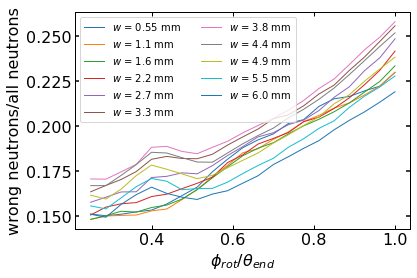

In [16]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from cycler import cycler
import new_log_spir.LogSpir as lgs
logspir = lgs.LogSpir(0.15, 0.3, 1.55, 5, 1e-8)
plt.style.use("/home/cherb/LRZSync/Doktorarbeit/Vorlagen_Verschiedenes/stylelibs/christoph.mplstyle")
mpl.rcParams['axes.prop_cycle'] = cycler('color', ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])

source_widths = np.linspace(0.0000001, 0.006, 12)
phi_rots = np.linspace(logspir.theta_end/4, logspir.theta_end, 21)
all_ratios = [0.1550508812793058, 0.15182434123556374, 0.15592402827763444, 0.1558515166463397, 0.1558493571826455, 0.16084306174597868, 0.1642873455661856, 0.17012138105191735, 0.1789177465916278, 0.18666448531782176, 0.19150826238398336, 0.19684965333279267, 0.2003185562374253, 0.20485928524927613, 0.21123222345211323, 0.21405698572278278, 0.21978233608042957, 0.2228506129608851, 0.22526625013266635, 0.22657446813252072, 0.22846408424459397, 0.1512987610637873, 0.15036052245362705, 0.15118645889614335, 0.15251379006828641, 0.15351202576720366, 0.15687730840478528, 0.16153448009462124, 0.16627640963673646, 0.17479651097747123, 0.18181634847991573, 0.18819967233696103, 0.19253967114254833, 0.1958321477125757, 0.2016860259053292, 0.20379050244831923, 0.21112947214417216, 0.21537848231056292, 0.21665882036494385, 0.21977503661188294, 0.22238045018925504, 0.23004566435523782, 0.14831506685360382, 0.15019151227809224, 0.1505624446152379, 0.15077058167221963, 0.15305408039280202, 0.15410669494916965, 0.15932985358797072, 0.16501017276144858, 0.17203998785022667, 0.1784423628356692, 0.18538461019637278, 0.18761237369053033, 0.19277686110319225, 0.19697542277831273, 0.20274430409289, 0.20610623452949114, 0.21018807402733733, 0.21307367285571366, 0.217497523194838, 0.22242769319468292, 0.2300962222249405, 0.14835068152013073, 0.15035585581500316, 0.15285512012682287, 0.1523735183840248, 0.15492627285426117, 0.156297762409462, 0.15962533569120996, 0.1648462769478046, 0.17144073178298952, 0.17760473678949662, 0.1837513533016259, 0.1878998499323938, 0.19094459713572415, 0.19588043500358993, 0.20035376985988307, 0.20398611208374615, 0.20817054316084171, 0.21308051178436482, 0.21913349321972544, 0.22501944604136342, 0.23368331345519208, 0.15075358683686288, 0.15515510297539795, 0.15700151690060543, 0.1576737535933084, 0.1610084641361108, 0.16236750157285695, 0.16539655402985595, 0.16839448157529585, 0.17180379259190523, 0.17991048665654316, 0.1842160157059123, 0.19022118636972177, 0.19332502266303572, 0.19662997720476957, 0.2026530561334658, 0.2051417339572716, 0.2100456413610045, 0.2159055888886864, 0.22323817716362676, 0.2312028030319398, 0.2418703429725604, 0.15786044455938675, 0.1606500166054714, 0.1635777947236995, 0.16368693340309506, 0.1716095961268993, 0.17226582439861815, 0.174210970538678, 0.1736665572914335, 0.17820263590047836, 0.1838501523962648, 0.18879992721118363, 0.19418136616322015, 0.19649353893464475, 0.2009889582966043, 0.20355397621013777, 0.20883861860621863, 0.2162041660297299, 0.2220594667479484, 0.23103954612027405, 0.23816606119757894, 0.24869194510964274, 0.16366768977989749, 0.16719449052430502, 0.17050175519535538, 0.17494101701721793, 0.18174005855504777, 0.18334574290712916, 0.18218976038881246, 0.18205646312088314, 0.18452626846118556, 0.1896496090111655, 0.19419970966593317, 0.1985569952622866, 0.20428541757486812, 0.20648134179958022, 0.2114897995970492, 0.21803362084501504, 0.22299952172052445, 0.23115605431550668, 0.23862743126645206, 0.2472423433872065, 0.2559191802911738, 0.1707925440996043, 0.17069290839500625, 0.17474056386930362, 0.1789360004375332, 0.1884112029736994, 0.18890657175715111, 0.1861082273971558, 0.18485090301864648, 0.18837697871851083, 0.1917779030264714, 0.1964345755573111, 0.20053582651406454, 0.2045076828183376, 0.20909796522781945, 0.21444566430420492, 0.2210857718522003, 0.2264059644092666, 0.2343982024412405, 0.24261618846514163, 0.2496147354470531, 0.2581970498134032, 0.16709999103567202, 0.16709023208391602, 0.17278179918964456, 0.17885778687650558, 0.18562441779116046, 0.1852228186542263, 0.182665621200013, 0.18021587208125117, 0.18011256170199424, 0.18528463770328732, 0.19037585605104293, 0.1949350308633574, 0.1990384393672465, 0.20476478101200662, 0.20956376109628205, 0.2150852320445, 0.22137861907744996, 0.2288398148936722, 0.2366350898508566, 0.24446650717263768, 0.25200268176172397, 0.1617898543544143, 0.15966448691087864, 0.16513095540936001, 0.17268132996305435, 0.17852907521213307, 0.17618817791720565, 0.1736077934505576, 0.1709652063356727, 0.17281003869010364, 0.17707027872154746, 0.1811876084900823, 0.18526072911964012, 0.19070982511780396, 0.1953822726793257, 0.2005480339008289, 0.20531405423907573, 0.21261444087265305, 0.21762351342593492, 0.2251843501086394, 0.23194594968549503, 0.2385134854242391, 0.15582513924222066, 0.15416511627537063, 0.16026435356992277, 0.166521020555237, 0.17108581760594713, 0.16952615041812163, 0.16481775327571166, 0.16545509300625774, 0.16558077826229745, 0.1690428265270874, 0.17381306137591976, 0.17828791207200975, 0.18227674895326174, 0.18846039363904235, 0.1931987469482629, 0.1989158947864685, 0.20313383446755676, 0.21061552391991153, 0.21685562359714844, 0.22195877364267153, 0.22804555862810202, 0.15119115574066244, 0.14952418198337977, 0.15666433161163262, 0.16209865963734837, 0.16626165241036017, 0.16278494252056913, 0.16066275540895292, 0.1594073287396579, 0.1623978150916634, 0.16428358445283076, 0.16848437947840722, 0.17258696431914283, 0.1787924795429448, 0.18319963872181388, 0.18784921714995167, 0.19210571685478153, 0.1981386321109835, 0.20340889730155273, 0.2081143102345794, 0.21350373471893422, 0.21928958133444876]
all_ratios = np.array(all_ratios).reshape((len(source_widths), len(phi_rots)))
fig, ax = plt.subplots(1)
for ind, ratio in enumerate(all_ratios[1:], 1):
    ax.plot(phi_rots/logspir.theta_end, ratio, marker=' ', linestyle='-', label='$w$ = {:.2} mm'.format(source_widths[ind]*1000))
ax.set_xlabel(r"$\phi_{rot}/\theta_{end}$")
ax.set_ylabel("wrong neutrons/all neutrons")
ax.legend(ncol=2)
fig.savefig("figures/influence_of_angle.pdf", bbox_inches='tight')
plt.show()